# Omission LFP Analysis

Brief 1-2 sentence description of notebook.

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import os
import glob
from collections import defaultdict
import re

In [3]:
# Imports of all used packages and libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
from scipy import stats
import itertools
from scipy.stats import linregress

In [4]:
import spikeinterface.extractors as se
import spikeinterface.preprocessing as sp
from spectral_connectivity import Multitaper, Connectivity
import spectral_connectivity

## Inputs & Data

Explanation of each input and where it comes from.

In [5]:
# Inputs and Required data loading
# input varaible names are in all caps snake case
# Whenever an input changes or is used for processing 
# the vairables are all lower in snake case

In [6]:
BBOX_TO_ANCHOR=(1.5, 0.9)
LOC='upper right'

In [7]:
ALL_BANDS = ["theta", "beta", "gamma"]
BAND_TO_FREQ = {"theta": {"low_freq": 4, "high_freq": 12}, "beta": {"low_freq": 13, "high_freq": 30}, "gamma": {"low_freq": 30, "high_freq": 70}}

In [8]:
# variables for LFP extraction
FREQ_MIN=0.5
FREQ_MAX=300
NOTCH_FREQ=60
ORIGINAL_SAMPLE_RATE = 20000
RESAMPLE_RATE=1000
TRIAL_DURATION=10

In [9]:
INPUT_VARIABLE = 1

TIME_HALFBANDWIDTH_PRODUCT = 2
TIME_WINDOW_DURATION = 3
TIME_WINDOW_STEP = 1.5 

TRIAL_TIME_STAMP_DURATION = 1000*10

In [10]:
BIN_TO_COLOR = {0: {"baseline": "lightblue", "trial": "blue"}, 1: {"baseline": "lightgreen", "trial": "green"}, 2: {"baseline": "lightcoral", "trial": "red"}}
TRIAL_OR_BASELINE_TO_STYLE = {'baseline': "--", "trial": "-"}
BIN_TO_VELOCITY = {0: "0 to 2.5cm/s", 1: "2.5 to 5cm/s", 2: "5cm/s+"}

In [11]:
NUM_LINES = 3

In [12]:
# Generate colors from the "Blues" colormap
LOSING_COLORS = cm.Oranges(np.linspace(0.5, 1, NUM_LINES))
# Generate colors from the "Blues" colormap
WINNING_COLORS = cm.Blues(np.linspace(0.5, 1, NUM_LINES))
# Generate colors from the "Blues" colormap
REWARDED_COLORS = cm.Greens(np.linspace(0.5, 1, NUM_LINES))
# Generate colors from the "Blues" colormap
OMISSION_COLORS = cm.Reds(np.linspace(0.5, 1, NUM_LINES))

In [164]:
BASELINE_OUTCOME_TO_COLOR = {'lose': "orange",
'lose_baseline': LOSING_COLORS[0],
'omission': "red",
'omission_baseline': "hotpink",
'rewarded': "green",
'rewarded_baseline': REWARDED_COLORS[0],
'win': "blue",
'win_baseline': WINNING_COLORS[0],
'lose_comp': "orange", 
'lose_non_comp': "yellow",
'win_comp': "blue", 
'win_non_comp': WINNING_COLORS[0]}

In [16]:
TRIAL_OR_BASELINE_TO_STYLE = {'baseline': "--", "trial": "-"}

In [17]:
CHANNEL_MAPPING_DF = pd.read_excel("./channel_mapping.xlsx")
CHANNEL_MAPPING_DF["Subject"] = CHANNEL_MAPPING_DF["Subject"].astype(str)

TONE_TIMESTAMP_DF = pd.read_excel("./rce_tone_timestamp.xlsx", index_col=0)
OUTPUT_DIR = r"./proc" # where data is saved should always be shown in the inputs


In [18]:
ALL_SESSION_DIR = list(set(['/scratch/back_up/reward_competition_extention/data/omission/2023_06_17/20230617_115521_standard_comp_to_omission_D1_subj_1-1_and_1-2.rec',
'/scratch/back_up/reward_competition_extention/data/omission/2023_06_18/20230618_100636_standard_comp_to_omission_D2_subj_1-4_and_1-1.rec',
'/scratch/back_up/reward_competition_extention/data/omission/2023_06_19/20230619_115321_standard_comp_to_omission_D3_subj_1-2_and_1-4.rec',
'/scratch/back_up/reward_competition_extention/data/omission/2023_06_20/20230620_114347_standard_comp_to_omission_D4_subj_1-2_and_1-1.rec',
'/scratch/back_up/reward_competition_extention/data/omission/2023_06_21/20230621_111240_standard_comp_to_omission_D5_subj_1-4_and_1-2.rec'
                   ]))

## Outputs

Describe each output that the notebook creates. 

- Is it a plot or is it data?

- How valuable is the output and why is it valuable or useful?

## Functions

- Ideally functions are defined here first and then data is processed using the functions
    - function names are short and in snake case all lowercase
    - a function name should be unique but does not have to describe the function
    - doc strings describe functions not function names

In [19]:
def generate_pairs(lst):
    pairs = []
    n = len(lst)
    for i in range(n):
        for j in range(i+1, n):
            pairs.append((lst[i], lst[j]))
    return pairs

In [20]:
def nested_dict():
    return defaultdict(dict)

triple_nested_dict = defaultdict(nested_dict)

## Processing

Describe what is done to the data here and how inputs are manipulated to generate outputs. 

In [21]:
# As much code and as many cells as required
# includes EDA and playing with data
# GO HAM!

In [22]:
CHANNEL_MAPPING_DF

Cohort Subject  eib_mPFC  eib_vHPC  eib_BLA  eib_LH  eib_MD  \
0       1     1.1       NaN        15       14      13      31   
1       1     1.2       NaN        15       14      13      31   
2       1     1.3       NaN        15       14      13      31   
3       1     1.4       NaN        15       14      13      31   
4       2     1.1       NaN        16       17      18      19   
5       2     1.2       NaN        31       30      29      28   
6       2     1.3       NaN        15       14      13      12   
7       2     1.4       NaN        15       14      13      12   

   spike_interface_mPFC  spike_interface_vHPC  spike_interface_BLA  \
0                   NaN                   NaN                  NaN   
1                   NaN                   NaN                  NaN   
2                   NaN                   NaN                  NaN   
3                   NaN                   NaN                  NaN   
4                   5.0                  31.0                 30.0   
5                  10.0                  31.0                 30.0   
6                   NaN                   NaN                  NaN   
7                   2.0                  31.0                 30.0   

   spike_interface_LH  spike_interface_MD  
0                 NaN                 NaN  
1                 NaN                 NaN  
2                 NaN                 NaN  
3                 NaN                 NaN  
4                29.0                28.0  
5                29.0                28.0  
6                 NaN                 NaN  
7                29.0                28.0

### Getting the subject IDs from the file name

In [23]:
all_trials_df = TONE_TIMESTAMP_DF.dropna(subset="condition").reset_index(drop=True)

In [24]:
all_trials_df = all_trials_df.drop_duplicates(subset=["recording_file", "time"], keep="first")

In [25]:
all_trials_df = all_trials_df[all_trials_df["recording_file"].str.contains("2023")].reset_index(drop=True).copy()

In [26]:
all_trials_df = all_trials_df[~all_trials_df["recording_dir"].str.contains("1-3")].reset_index(drop=True).copy()

In [27]:
all_trials_df.head()

time  state                                      recording_dir  \
0   4509412.0    1.0  20230617_115521_standard_comp_to_omission_D1_s...   
1   6909411.0    1.0  20230617_115521_standard_comp_to_omission_D1_s...   
2   9209413.0    1.0  20230617_115521_standard_comp_to_omission_D1_s...   
3  11009410.0    1.0  20230617_115521_standard_comp_to_omission_D1_s...   
4  12109413.0    1.0  20230617_115521_standard_comp_to_omission_D1_s...   

                                      recording_file           din  \
0  20230617_115521_standard_comp_to_omission_D1_s...  dio_ECU_Din1   
1  20230617_115521_standard_comp_to_omission_D1_s...  dio_ECU_Din1   
2  20230617_115521_standard_comp_to_omission_D1_s...  dio_ECU_Din1   
3  20230617_115521_standard_comp_to_omission_D1_s...  dio_ECU_Din1   
4  20230617_115521_standard_comp_to_omission_D1_s...  dio_ECU_Din1   

   time_stamp_index                                         video_file  \
0         1030879.0  20230617_115521_standard_comp_to_omission_D1_s...   
1         3430878.0  20230617_115521_standard_comp_to_omission_D1_s...   
2         5730880.0  20230617_115521_standard_comp_to_omission_D1_s...   
3         7530877.0  20230617_115521_standard_comp_to_omission_D1_s...   
4         8630880.0  20230617_115521_standard_comp_to_omission_D1_s...   

   video_frame  video_number    subject_info condition  \
0       1029.0           1.0  1-1_t1b3L_box1       1.2   
1       3425.0           1.0  1-1_t1b3L_box1       1.1   
2       5720.0           1.0  1-1_t1b3L_box1       1.1   
3       7516.0           1.0  1-1_t1b3L_box1       1.2   
4       8615.0           1.0  1-1_t1b3L_box1       1.1   

    competition_closeness Unnamed: 13  
0  Subj 2 blocking Subj 1         NaN  
1  Subj 1 blocking Subj 2         NaN  
2  Subj 1 blocking Subj 2         NaN  
3             Subj 2 Only         NaN  
4             Subj 1 Only         NaN

- Original timestamps are based on ephys recordings at 20kHz. The LFP will be at 1kHz, so we will need to divide all the timestamps by 20

In [28]:
all_trials_df["resampled_index"] = all_trials_df["time_stamp_index"] // (ORIGINAL_SAMPLE_RATE // RESAMPLE_RATE)

In [29]:
all_trials_df["recording_dir"].unique()

array(['20230617_115521_standard_comp_to_omission_D1_subj_1-1_and_1-2',
       '20230618_100636_standard_comp_to_omission_D2_subj_1-4_and_1-1',
       '20230619_115321_standard_comp_to_omission_D3_subj_1-2_and_1-4',
       '20230620_114347_standard_comp_to_omission_D4_subj_1-2_and_1-1',
       '20230621_111240_standard_comp_to_omission_D5_subj_1-4_and_1-2'],
      dtype=object)

- Getting a list of all the subjects through the recording name

In [30]:
all_trials_df["all_subjects"] = all_trials_df["recording_dir"].apply(lambda x: ["{}.{}".format(tup[0],tup[1]) for tup in re.findall(r'(\d+)-(\d+)', x.replace("_", "-"))[1:]])

In [31]:
all_trials_df["all_subjects"].head()

0    [1.1, 1.2]
1    [1.1, 1.2]
2    [1.1, 1.2]
3    [1.1, 1.2]
4    [1.1, 1.2]
Name: all_subjects, dtype: object

- Getting the current subject of the recording through the ending of the recording name file

In [32]:
all_trials_df["subject_info"].head()

0    1-1_t1b3L_box1
1    1-1_t1b3L_box1
2    1-1_t1b3L_box1
3    1-1_t1b3L_box1
4    1-1_t1b3L_box1
Name: subject_info, dtype: object

In [33]:
all_trials_df["current_subject"] = all_trials_df["subject_info"].apply(lambda x: ".".join(x.replace("-","_").split("_")[:2]))

In [34]:
all_trials_df.head()

time  state                                      recording_dir  \
0   4509412.0    1.0  20230617_115521_standard_comp_to_omission_D1_s...   
1   6909411.0    1.0  20230617_115521_standard_comp_to_omission_D1_s...   
2   9209413.0    1.0  20230617_115521_standard_comp_to_omission_D1_s...   
3  11009410.0    1.0  20230617_115521_standard_comp_to_omission_D1_s...   
4  12109413.0    1.0  20230617_115521_standard_comp_to_omission_D1_s...   

                                      recording_file           din  \
0  20230617_115521_standard_comp_to_omission_D1_s...  dio_ECU_Din1   
1  20230617_115521_standard_comp_to_omission_D1_s...  dio_ECU_Din1   
2  20230617_115521_standard_comp_to_omission_D1_s...  dio_ECU_Din1   
3  20230617_115521_standard_comp_to_omission_D1_s...  dio_ECU_Din1   
4  20230617_115521_standard_comp_to_omission_D1_s...  dio_ECU_Din1   

   time_stamp_index                                         video_file  \
0         1030879.0  20230617_115521_standard_comp_to_omission_D1_s...   
1         3430878.0  20230617_115521_standard_comp_to_omission_D1_s...   
2         5730880.0  20230617_115521_standard_comp_to_omission_D1_s...   
3         7530877.0  20230617_115521_standard_comp_to_omission_D1_s...   
4         8630880.0  20230617_115521_standard_comp_to_omission_D1_s...   

   video_frame  video_number    subject_info condition  \
0       1029.0           1.0  1-1_t1b3L_box1       1.2   
1       3425.0           1.0  1-1_t1b3L_box1       1.1   
2       5720.0           1.0  1-1_t1b3L_box1       1.1   
3       7516.0           1.0  1-1_t1b3L_box1       1.2   
4       8615.0           1.0  1-1_t1b3L_box1       1.1   

    competition_closeness Unnamed: 13  resampled_index all_subjects  \
0  Subj 2 blocking Subj 1         NaN          51543.0   [1.1, 1.2]   
1  Subj 1 blocking Subj 2         NaN         171543.0   [1.1, 1.2]   
2  Subj 1 blocking Subj 2         NaN         286544.0   [1.1, 1.2]   
3             Subj 2 Only         NaN         376543.0   [1.1, 1.2]   
4             Subj 1 Only         NaN         431544.0   [1.1, 1.2]   

  current_subject  
0             1.1  
1             1.1  
2             1.1  
3             1.1  
4             1.1

In [35]:
all_trials_df

time  state                                      recording_dir  \
0     4509412.0    1.0  20230617_115521_standard_comp_to_omission_D1_s...   
1     6909411.0    1.0  20230617_115521_standard_comp_to_omission_D1_s...   
2     9209413.0    1.0  20230617_115521_standard_comp_to_omission_D1_s...   
3    11009410.0    1.0  20230617_115521_standard_comp_to_omission_D1_s...   
4    12109413.0    1.0  20230617_115521_standard_comp_to_omission_D1_s...   
..          ...    ...                                                ...   
254  65281838.0    1.0  20230621_111240_standard_comp_to_omission_D5_s...   
255  66781856.0    1.0  20230621_111240_standard_comp_to_omission_D5_s...   
256  68781880.0    1.0  20230621_111240_standard_comp_to_omission_D5_s...   
257  70681909.0    1.0  20230621_111240_standard_comp_to_omission_D5_s...   
258  71681918.0    1.0  20230621_111240_standard_comp_to_omission_D5_s...   

                                        recording_file           din  \
0    20230617_115521_standard_comp_to_omission_D1_s...  dio_ECU_Din1   
1    20230617_115521_standard_comp_to_omission_D1_s...  dio_ECU_Din1   
2    20230617_115521_standard_comp_to_omission_D1_s...  dio_ECU_Din1   
3    20230617_115521_standard_comp_to_omission_D1_s...  dio_ECU_Din1   
4    20230617_115521_standard_comp_to_omission_D1_s...  dio_ECU_Din1   
..                                                 ...           ...   
254  20230621_111240_standard_comp_to_omission_D5_s...  dio_ECU_Din1   
255  20230621_111240_standard_comp_to_omission_D5_s...  dio_ECU_Din1   
256  20230621_111240_standard_comp_to_omission_D5_s...  dio_ECU_Din1   
257  20230621_111240_standard_comp_to_omission_D5_s...  dio_ECU_Din1   
258  20230621_111240_standard_comp_to_omission_D5_s...  dio_ECU_Din1   

     time_stamp_index                                         video_file  \
0           1030879.0  20230617_115521_standard_comp_to_omission_D1_s...   
1           3430878.0  20230617_115521_standard_comp_to_omission_D1_s...   
2           5730880.0  20230617_115521_standard_comp_to_omission_D1_s...   
3           7530877.0  20230617_115521_standard_comp_to_omission_D1_s...   
4           8630880.0  20230617_115521_standard_comp_to_omission_D1_s...   
..                ...                                                ...   
254        62088794.0  20230621_111240_standard_comp_to_omission_D5_s...   
255        63588812.0  20230621_111240_standard_comp_to_omission_D5_s...   
256        65588836.0  20230621_111240_standard_comp_to_omission_D5_s...   
257        67488865.0  20230621_111240_standard_comp_to_omission_D5_s...   
258        68488874.0  20230621_111240_standard_comp_to_omission_D5_s...   

     video_frame  video_number    subject_info condition  \
0         1029.0           1.0  1-1_t1b3L_box1       1.2   
1         3425.0           1.0  1-1_t1b3L_box1       1.1   
2         5720.0           1.0  1-1_t1b3L_box1       1.1   
3         7516.0           1.0  1-1_t1b3L_box1       1.2   
4         8615.0           1.0  1-1_t1b3L_box1       1.1   
..           ...           ...             ...       ...   
254      62056.0           1.0  1-4_t3b3L_box1  rewarded   
255      63554.0           1.0  1-4_t3b3L_box1  rewarded   
256      65550.0           1.0  1-4_t3b3L_box1  rewarded   
257      67447.0           1.0  1-4_t3b3L_box1  omission   
258      68444.0           1.0  1-4_t3b3L_box1  rewarded   

      competition_closeness Unnamed: 13  resampled_index all_subjects  \
0    Subj 2 blocking Subj 1         NaN          51543.0   [1.1, 1.2]   
1    Subj 1 blocking Subj 2         NaN         171543.0   [1.1, 1.2]   
2    Subj 1 blocking Subj 2         NaN         286544.0   [1.1, 1.2]   
3               Subj 2 Only         NaN         376543.0   [1.1, 1.2]   
4               Subj 1 Only         NaN         431544.0   [1.1, 1.2]   
..                      ...         ...              ...          ...   
254                     NaN    rewarded        3104439.0   [1.4, 1.2]   
255

- Labeling the trial as a winner or loser if the winner matches the subject id or not

In [36]:
all_trials_df["trial_outcome"] = all_trials_df.apply(
    lambda x: "win" if str(x["condition"]).strip() == str(x["current_subject"]) 
             else ("lose" if str(x["condition"]) in x["all_subjects"] 
                   else x["condition"]), axis=1)

In [37]:
all_trials_df.head()

time  state                                      recording_dir  \
0   4509412.0    1.0  20230617_115521_standard_comp_to_omission_D1_s...   
1   6909411.0    1.0  20230617_115521_standard_comp_to_omission_D1_s...   
2   9209413.0    1.0  20230617_115521_standard_comp_to_omission_D1_s...   
3  11009410.0    1.0  20230617_115521_standard_comp_to_omission_D1_s...   
4  12109413.0    1.0  20230617_115521_standard_comp_to_omission_D1_s...   

                                      recording_file           din  \
0  20230617_115521_standard_comp_to_omission_D1_s...  dio_ECU_Din1   
1  20230617_115521_standard_comp_to_omission_D1_s...  dio_ECU_Din1   
2  20230617_115521_standard_comp_to_omission_D1_s...  dio_ECU_Din1   
3  20230617_115521_standard_comp_to_omission_D1_s...  dio_ECU_Din1   
4  20230617_115521_standard_comp_to_omission_D1_s...  dio_ECU_Din1   

   time_stamp_index                                         video_file  \
0         1030879.0  20230617_115521_standard_comp_to_omission_D1_s...   
1         3430878.0  20230617_115521_standard_comp_to_omission_D1_s...   
2         5730880.0  20230617_115521_standard_comp_to_omission_D1_s...   
3         7530877.0  20230617_115521_standard_comp_to_omission_D1_s...   
4         8630880.0  20230617_115521_standard_comp_to_omission_D1_s...   

   video_frame  video_number    subject_info condition  \
0       1029.0           1.0  1-1_t1b3L_box1       1.2   
1       3425.0           1.0  1-1_t1b3L_box1       1.1   
2       5720.0           1.0  1-1_t1b3L_box1       1.1   
3       7516.0           1.0  1-1_t1b3L_box1       1.2   
4       8615.0           1.0  1-1_t1b3L_box1       1.1   

    competition_closeness Unnamed: 13  resampled_index all_subjects  \
0  Subj 2 blocking Subj 1         NaN          51543.0   [1.1, 1.2]   
1  Subj 1 blocking Subj 2         NaN         171543.0   [1.1, 1.2]   
2  Subj 1 blocking Subj 2         NaN         286544.0   [1.1, 1.2]   
3             Subj 2 Only         NaN         376543.0   [1.1, 1.2]   
4             Subj 1 Only         NaN         431544.0   [1.1, 1.2]   

  current_subject trial_outcome  
0             1.1          lose  
1             1.1           win  
2             1.1           win  
3             1.1          lose  
4             1.1           win

In [38]:
competition_closeness_map = {k: "non_comp" if "only" in str(k).lower() else "comp" if type(k) is str else np.nan for k in all_trials_df["competition_closeness"].unique()}

In [39]:
competition_closeness_map

{'Subj 2 blocking Subj 1': 'comp',
 'Subj 1 blocking Subj 2': 'comp',
 'Subj 2 Only': 'non_comp',
 'Subj 1 Only': 'non_comp',
 'Subj 1 then Subj 2': 'comp',
 'Subj 2 then Subj 1': 'comp',
 'Close Call': 'comp',
 nan: nan}

In [40]:
all_trials_df["competition_closeness"] = all_trials_df["competition_closeness"].map(competition_closeness_map)

In [41]:
all_trials_df["competition_closeness"]

0          comp
1          comp
2          comp
3      non_comp
4      non_comp
         ...   
254         NaN
255         NaN
256         NaN
257         NaN
258         NaN
Name: competition_closeness, Length: 259, dtype: object

In [42]:
all_trials_df["competition_closeness"] = all_trials_df.apply(lambda x: "_".join([str(x["trial_outcome"]), str(x["competition_closeness"])]).strip("nan").strip("_"), axis=1)

### Extracting the LFP

In [43]:
recording_name_to_all_ch_lfp = {}
# Going through all the recording sessions 
for session_dir in ALL_SESSION_DIR:
    # Going through all the recordings in each session
    for recording_path in glob.glob(os.path.join(session_dir, "*.rec")):
        try:
            recording_basename = os.path.splitext(os.path.basename(recording_path))[0]
            # checking to see if the recording has an ECU component
            # if it doesn't, then the next one be extracted
            current_recording = se.read_spikegadgets(recording_path, stream_id="ECU")
            current_recording = se.read_spikegadgets(recording_path, stream_id="trodes")
            print(recording_basename)
            # Preprocessing the LFP
            current_recording = sp.bandpass_filter(current_recording, freq_min=FREQ_MIN, freq_max=FREQ_MAX)
            current_recording = sp.notch_filter(current_recording, freq=NOTCH_FREQ)
            current_recording = sp.resample(current_recording, resample_rate=RESAMPLE_RATE)
            current_recording = sp.zscore(current_recording)
            recording_name_to_all_ch_lfp[recording_basename] = current_recording
        except:
            pass



20230619_115321_standard_comp_to_omission_D3_subj_1-4_t3b3L_box2_merged
20230620_114347_standard_comp_to_omission_D4_subj_1-1_t1b2L_box_2_merged
20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
20230621_111240_standard_comp_to_omission_D5_subj_1-4_t3b3L_box1_merged
20230617_115521_standard_comp_to_omission_D1_subj_1-2_t2b2L_box2_merged
20230617_115521_standard_comp_to_omission_D1_subj_1-1_t1b3L_box1_merged
20230618_100636_standard_comp_to_omission_D2_subj_1_4_t4b3L_box1_merged
20230618_100636_standard_comp_to_omission_D2_subj_1_1_t1b2L_box2_merged


- Filtering for all trials that have labels

In [44]:
all_trials_df = all_trials_df[all_trials_df["recording_file"].isin(recording_name_to_all_ch_lfp.keys())].reset_index(drop=True)

In [45]:
all_trials_df.head()

time  state                                      recording_dir  \
0   4509412.0    1.0  20230617_115521_standard_comp_to_omission_D1_s...   
1   6909411.0    1.0  20230617_115521_standard_comp_to_omission_D1_s...   
2   9209413.0    1.0  20230617_115521_standard_comp_to_omission_D1_s...   
3  11009410.0    1.0  20230617_115521_standard_comp_to_omission_D1_s...   
4  12109413.0    1.0  20230617_115521_standard_comp_to_omission_D1_s...   

                                      recording_file           din  \
0  20230617_115521_standard_comp_to_omission_D1_s...  dio_ECU_Din1   
1  20230617_115521_standard_comp_to_omission_D1_s...  dio_ECU_Din1   
2  20230617_115521_standard_comp_to_omission_D1_s...  dio_ECU_Din1   
3  20230617_115521_standard_comp_to_omission_D1_s...  dio_ECU_Din1   
4  20230617_115521_standard_comp_to_omission_D1_s...  dio_ECU_Din1   

   time_stamp_index                                         video_file  \
0         1030879.0  20230617_115521_standard_comp_to_omission_D1_s...   
1         3430878.0  20230617_115521_standard_comp_to_omission_D1_s...   
2         5730880.0  20230617_115521_standard_comp_to_omission_D1_s...   
3         7530877.0  20230617_115521_standard_comp_to_omission_D1_s...   
4         8630880.0  20230617_115521_standard_comp_to_omission_D1_s...   

   video_frame  video_number    subject_info condition competition_closeness  \
0       1029.0           1.0  1-1_t1b3L_box1       1.2             lose_comp   
1       3425.0           1.0  1-1_t1b3L_box1       1.1              win_comp   
2       5720.0           1.0  1-1_t1b3L_box1       1.1              win_comp   
3       7516.0           1.0  1-1_t1b3L_box1       1.2         lose_non_comp   
4       8615.0           1.0  1-1_t1b3L_box1       1.1          win_non_comp   

  Unnamed: 13  resampled_index all_subjects current_subject trial_outcome  
0         NaN          51543.0   [1.1, 1.2]             1.1          lose  
1         NaN         171543.0   [1.1, 1.2]             1.1           win  
2         NaN         286544.0   [1.1, 1.2]             1.1           win  
3         NaN         376543.0   [1.1, 1.2]             1.1          lose  
4         NaN         431544.0   [1.1, 1.2]             1.1           win

In [46]:
all_trials_df["trial_outcome"].unique()

array(['lose', 'win', 'rewarded', 'omission'], dtype=object)

# Extracting the LFP

In [47]:
all_trials_df.head()

time  state                                      recording_dir  \
0   4509412.0    1.0  20230617_115521_standard_comp_to_omission_D1_s...   
1   6909411.0    1.0  20230617_115521_standard_comp_to_omission_D1_s...   
2   9209413.0    1.0  20230617_115521_standard_comp_to_omission_D1_s...   
3  11009410.0    1.0  20230617_115521_standard_comp_to_omission_D1_s...   
4  12109413.0    1.0  20230617_115521_standard_comp_to_omission_D1_s...   

                                      recording_file           din  \
0  20230617_115521_standard_comp_to_omission_D1_s...  dio_ECU_Din1   
1  20230617_115521_standard_comp_to_omission_D1_s...  dio_ECU_Din1   
2  20230617_115521_standard_comp_to_omission_D1_s...  dio_ECU_Din1   
3  20230617_115521_standard_comp_to_omission_D1_s...  dio_ECU_Din1   
4  20230617_115521_standard_comp_to_omission_D1_s...  dio_ECU_Din1   

   time_stamp_index                                         video_file  \
0         1030879.0  20230617_115521_standard_comp_to_omission_D1_s...   
1         3430878.0  20230617_115521_standard_comp_to_omission_D1_s...   
2         5730880.0  20230617_115521_standard_comp_to_omission_D1_s...   
3         7530877.0  20230617_115521_standard_comp_to_omission_D1_s...   
4         8630880.0  20230617_115521_standard_comp_to_omission_D1_s...   

   video_frame  video_number    subject_info condition competition_closeness  \
0       1029.0           1.0  1-1_t1b3L_box1       1.2             lose_comp   
1       3425.0           1.0  1-1_t1b3L_box1       1.1              win_comp   
2       5720.0           1.0  1-1_t1b3L_box1       1.1              win_comp   
3       7516.0           1.0  1-1_t1b3L_box1       1.2         lose_non_comp   
4       8615.0           1.0  1-1_t1b3L_box1       1.1          win_non_comp   

  Unnamed: 13  resampled_index all_subjects current_subject trial_outcome  
0         NaN          51543.0   [1.1, 1.2]             1.1          lose  
1         NaN         171543.0   [1.1, 1.2]             1.1           win  
2         NaN         286544.0   [1.1, 1.2]             1.1           win  
3         NaN         376543.0   [1.1, 1.2]             1.1          lose  
4         NaN         431544.0   [1.1, 1.2]             1.1           win

In [48]:
CHANNEL_MAPPING_DF

Cohort Subject  eib_mPFC  eib_vHPC  eib_BLA  eib_LH  eib_MD  \
0       1     1.1       NaN        15       14      13      31   
1       1     1.2       NaN        15       14      13      31   
2       1     1.3       NaN        15       14      13      31   
3       1     1.4       NaN        15       14      13      31   
4       2     1.1       NaN        16       17      18      19   
5       2     1.2       NaN        31       30      29      28   
6       2     1.3       NaN        15       14      13      12   
7       2     1.4       NaN        15       14      13      12   

   spike_interface_mPFC  spike_interface_vHPC  spike_interface_BLA  \
0                   NaN                   NaN                  NaN   
1                   NaN                   NaN                  NaN   
2                   NaN                   NaN                  NaN   
3                   NaN                   NaN                  NaN   
4                   5.0                  31.0                 30.0   
5                  10.0                  31.0                 30.0   
6                   NaN                   NaN                  NaN   
7                   2.0                  31.0                 30.0   

   spike_interface_LH  spike_interface_MD  
0                 NaN                 NaN  
1                 NaN                 NaN  
2                 NaN                 NaN  
3                 NaN                 NaN  
4                29.0                28.0  
5                29.0                28.0  
6                 NaN                 NaN  
7                29.0                28.0

- Adding all the brain region to ch information

In [49]:
channel_map_and_all_trials_df = all_trials_df.merge(CHANNEL_MAPPING_DF, left_on="current_subject", right_on="Subject", how="left")

- Linking up all LFP calculations with all the trials

In [50]:
channel_map_and_all_trials_df["all_ch_lfp"] = channel_map_and_all_trials_df["recording_file"].map(recording_name_to_all_ch_lfp)

In [51]:
channel_map_and_all_trials_df.head()

time  state                                      recording_dir  \
0  4509412.0    1.0  20230617_115521_standard_comp_to_omission_D1_s...   
1  4509412.0    1.0  20230617_115521_standard_comp_to_omission_D1_s...   
2  6909411.0    1.0  20230617_115521_standard_comp_to_omission_D1_s...   
3  6909411.0    1.0  20230617_115521_standard_comp_to_omission_D1_s...   
4  9209413.0    1.0  20230617_115521_standard_comp_to_omission_D1_s...   

                                      recording_file           din  \
0  20230617_115521_standard_comp_to_omission_D1_s...  dio_ECU_Din1   
1  20230617_115521_standard_comp_to_omission_D1_s...  dio_ECU_Din1   
2  20230617_115521_standard_comp_to_omission_D1_s...  dio_ECU_Din1   
3  20230617_115521_standard_comp_to_omission_D1_s...  dio_ECU_Din1   
4  20230617_115521_standard_comp_to_omission_D1_s...  dio_ECU_Din1   

   time_stamp_index                                         video_file  \
0         1030879.0  20230617_115521_standard_comp_to_omission_D1_s...   
1         1030879.0  20230617_115521_standard_comp_to_omission_D1_s...   
2         3430878.0  20230617_115521_standard_comp_to_omission_D1_s...   
3         3430878.0  20230617_115521_standard_comp_to_omission_D1_s...   
4         5730880.0  20230617_115521_standard_comp_to_omission_D1_s...   

   video_frame  video_number    subject_info  ... eib_vHPC eib_BLA eib_LH  \
0       1029.0           1.0  1-1_t1b3L_box1  ...       15      14     13   
1       1029.0           1.0  1-1_t1b3L_box1  ...       16      17     18   
2       3425.0           1.0  1-1_t1b3L_box1  ...       15      14     13   
3       3425.0           1.0  1-1_t1b3L_box1  ...       16      17     18   
4       5720.0           1.0  1-1_t1b3L_box1  ...       15      14     13   

   eib_MD spike_interface_mPFC spike_interface_vHPC spike_interface_BLA  \
0      31                  NaN                  NaN                 NaN   
1      19                  5.0                 31.0                30.0   
2      31                  NaN                  NaN                 NaN   
3      19                  5.0                 31.0                30.0   
4      31                  NaN                  NaN                 NaN   

   spike_interface_LH spike_interface_MD  \
0                 NaN                NaN   
1                29.0               28.0   
2                 NaN                NaN   
3                29.0               28.0   
4                 NaN                NaN   

                                          all_ch_lfp  
0  ZScoreRecording: 32 channels - 1 segments - 1....  
1  ZScoreRecording: 32 channels - 1 segments - 1....  
2  ZScoreRecording: 32 channels - 1 segments - 1....  
3  ZScoreRecording: 32 channels - 1 segments - 1....  
4  ZScoreRecording: 32 channels - 1 segments - 1....  

[5 rows x 30 columns]

- Getting the LFP indexes for each trial before and after the tone

In [52]:
channel_map_and_all_trials_df["resampled_index"] = channel_map_and_all_trials_df["resampled_index"].astype(int)

In [53]:
# Getting the LFP index for the trial portion
trial_channel_map_and_all_trials_df = channel_map_and_all_trials_df.copy()
trial_channel_map_and_all_trials_df["trial_or_baseline"] = "trial"
trial_channel_map_and_all_trials_df["trial_or_baseline_entire_lfp_index"] = trial_channel_map_and_all_trials_df["resampled_index"].apply(lambda x: (x, x+RESAMPLE_RATE*TRIAL_DURATION,))

# Getting the LFP index for the baseline portion
baseline_channel_map_and_all_trials_df = channel_map_and_all_trials_df.copy()
baseline_channel_map_and_all_trials_df["trial_or_baseline"] = "baseline"
baseline_channel_map_and_all_trials_df["trial_or_baseline_entire_lfp_index"] = baseline_channel_map_and_all_trials_df["resampled_index"].apply(lambda x: (x-RESAMPLE_RATE*TRIAL_DURATION, x))

- Combining the dataframe for the trial and baseline portions

In [54]:
channel_map_and_all_trials_df = pd.concat([trial_channel_map_and_all_trials_df, baseline_channel_map_and_all_trials_df])

In [55]:
channel_map_and_all_trials_df["trial_or_baseline_entire_lfp_index"].head()

0      (51543, 61543)
1      (51543, 61543)
2    (171543, 181543)
3    (171543, 181543)
4    (286544, 296544)
Name: trial_or_baseline_entire_lfp_index, dtype: object

- Getting the LFP for each brain region

In [56]:
channel_columns = sorted([col for col in channel_map_and_all_trials_df.columns if "spike" in col])

In [57]:
channel_columns

['spike_interface_BLA',
 'spike_interface_LH',
 'spike_interface_MD',
 'spike_interface_mPFC',
 'spike_interface_vHPC']

In [58]:
channel_map_and_all_trials_df["spike_interface_BLA"].unique()

array([nan, 30.])

In [59]:
current_df =  channel_map_and_all_trials_df.copy()
for col in channel_columns:
    print(col)
    current_df = current_df.dropna(subset=[col])
    current_df["{}_trace".format(col.strip("spike_interface").strip("_"))] = current_df.apply(lambda x: 
x["all_ch_lfp"].get_traces(channel_ids=[str(int(x[col]))], start_frame=x["trial_or_baseline_entire_lfp_index"][0], end_frame=x["trial_or_baseline_entire_lfp_index"][-1] ).T[0][:RESAMPLE_RATE*TRIAL_DURATION], axis=1)

spike_interface_BLA
spike_interface_LH
spike_interface_MD
spike_interface_mPFC
spike_interface_vHPC


## Power calculation for each trial for each brain region

In [63]:
trace_columns = [col for col in current_df.columns if "trace" in col]

In [64]:
trace_columns

['BLA_trace', 'LH_trace', 'MD_trace', 'mPFC_trace', 'vHPC_trace']

In [65]:
channel_map_and_all_trials_df = current_df

In [66]:
for region in trace_columns:
    region_base_name = "{}".format(region.strip("trace").strip("_"))
    print(region_base_name)
    # Getting the multitaper from each brain region
    multitaper_col = "{}_multitaper".format(region_base_name)
    channel_map_and_all_trials_df[multitaper_col] = channel_map_and_all_trials_df[region].apply(lambda x: Multitaper(time_series=x, sampling_frequency=RESAMPLE_RATE))
    # Getting the connectivity from each brain region, 
    # which has the power for the trace
    connectivity_col = "{}_connectivity".format(region_base_name)
    channel_map_and_all_trials_df[connectivity_col] = channel_map_and_all_trials_df[multitaper_col].apply(lambda x: Connectivity.from_multitaper(x))
    channel_map_and_all_trials_df["{}_power".format(region_base_name)] = channel_map_and_all_trials_df[connectivity_col].apply(lambda x: x.power().squeeze())
    # Getting the frequencies for each power
    channel_map_and_all_trials_df["{}_frequencies".format(region_base_name)] = channel_map_and_all_trials_df[connectivity_col].apply(lambda x: x.frequencies)

BLA
LH
MD
mPFC
vHPC


In [67]:
for region in trace_columns:
    region_base_name = "{}".format(region.strip("trace").strip("_"))

    connectivity_col = "{}_connectivity".format(region_base_name)

    channel_map_and_all_trials_df["{}_power".format(region_base_name)] = channel_map_and_all_trials_df[connectivity_col].apply(lambda x: x.power().squeeze())

- Averaging the powers for each band

In [68]:
ALL_BANDS

['theta', 'beta', 'gamma']

In [69]:
BAND_TO_FREQ

{'theta': {'low_freq': 4, 'high_freq': 12},
 'beta': {'low_freq': 13, 'high_freq': 30},
 'gamma': {'low_freq': 30, 'high_freq': 70}}

In [70]:
for region in trace_columns:    
    region_base_name = "{}".format(region.strip("trace").strip("_"))
    print(region_base_name)
    
    for band in ALL_BANDS:
        channel_map_and_all_trials_df["{}_averaged_{}_power".format(region_base_name, band)] = channel_map_and_all_trials_df["{}_power".format(region_base_name)].apply(lambda x: np.mean(x[BAND_TO_FREQ[band]["low_freq"]*10:BAND_TO_FREQ[band]["high_freq"]*10+1]))

        


BLA
LH
MD
mPFC
vHPC


## Power correlation between brain regions calculation

In [131]:
back_up_channel_map_and_all_trials_df = channel_map_and_all_trials_df.copy()

In [132]:
channel_map_and_all_trials_df = channel_map_and_all_trials_df[~channel_map_and_all_trials_df["competition_closeness"].isin(['lose_non_comp', 'win_non_comp'])]

- Combining the trial/baseline and outcome label for coloring

In [133]:
channel_map_and_all_trials_df["outcome_and_trial_or_baseline"] = channel_map_and_all_trials_df.apply(lambda x: "_".join([x["trial_outcome"], x["trial_or_baseline"]]), axis=1)

- Filtering out the outliers

In [134]:
from scipy.stats import zscore

In [168]:
band_to_power_correlation = defaultdict(dict)
for band in ALL_BANDS:
    # Getting all the pairs of brain regions
    band_averaged_columns = [col for col in channel_map_and_all_trials_df.columns if "averaged_{}".format(band) in col]
    band_to_power_correlation[band]["brain_region_pairs"] = generate_pairs(band_averaged_columns)
    print(band_to_power_correlation[band]["brain_region_pairs"])

    # Removing rows that are outliers
    filtered_df = channel_map_and_all_trials_df.copy()
    
    band_to_power_correlation[band]["outlier_removed_df"] = filtered_df[(np.abs(zscore(filtered_df[band_averaged_columns])) <= 3).all(axis=1)].copy()


    
    # Getting the mean and standard deviation
    

[('BLA_averaged_theta_power', 'LH_averaged_theta_power'), ('BLA_averaged_theta_power', 'MD_averaged_theta_power'), ('BLA_averaged_theta_power', 'mPFC_averaged_theta_power'), ('BLA_averaged_theta_power', 'vHPC_averaged_theta_power'), ('LH_averaged_theta_power', 'MD_averaged_theta_power'), ('LH_averaged_theta_power', 'mPFC_averaged_theta_power'), ('LH_averaged_theta_power', 'vHPC_averaged_theta_power'), ('MD_averaged_theta_power', 'mPFC_averaged_theta_power'), ('MD_averaged_theta_power', 'vHPC_averaged_theta_power'), ('mPFC_averaged_theta_power', 'vHPC_averaged_theta_power')]
[('BLA_averaged_beta_power', 'LH_averaged_beta_power'), ('BLA_averaged_beta_power', 'MD_averaged_beta_power'), ('BLA_averaged_beta_power', 'mPFC_averaged_beta_power'), ('BLA_averaged_beta_power', 'vHPC_averaged_beta_power'), ('LH_averaged_beta_power', 'MD_averaged_beta_power'), ('LH_averaged_beta_power', 'mPFC_averaged_beta_power'), ('LH_averaged_beta_power', 'vHPC_averaged_beta_power'), ('MD_averaged_beta_power', '

In [169]:
channel_map_and_all_trials_df.columns

Index(['time', 'state', 'recording_dir', 'recording_file', 'din',
       'time_stamp_index', 'video_file', 'video_frame', 'video_number',
       'subject_info', 'condition', 'competition_closeness', 'Unnamed: 13',
       'resampled_index', 'all_subjects', 'current_subject', 'trial_outcome',
       'Cohort', 'Subject', 'eib_mPFC', 'eib_vHPC', 'eib_BLA', 'eib_LH',
       'eib_MD', 'spike_interface_mPFC', 'spike_interface_vHPC',
       'spike_interface_BLA', 'spike_interface_LH', 'spike_interface_MD',
       'all_ch_lfp', 'trial_or_baseline', 'trial_or_baseline_entire_lfp_index',
       'BLA_trace', 'LH_trace', 'MD_trace', 'mPFC_trace', 'vHPC_trace',
       'BLA_multitaper', 'BLA_connectivity', 'BLA_power', 'BLA_frequencies',
       'LH_multitaper', 'LH_connectivity', 'LH_power', 'LH_frequencies',
       'MD_multitaper', 'MD_connectivity', 'MD_power', 'MD_frequencies',
       'mPFC_multitaper', 'mPFC_connectivity', 'mPFC_power',
       'mPFC_frequencies', 'vHPC_multitaper', 'vHPC_connecti

In [170]:
channel_map_and_all_trials_df.shape

(392, 73)

In [171]:
band_to_power_correlation[band]["outlier_removed_df"].shape

(377, 73)

- Plotting all of the conditions

In [172]:
# band_to_power_correlation = defaultdict(dict)
for band in ALL_BANDS:
    # Getting all the pairs of brain regions
    band_averaged_columns = [col for col in channel_map_and_all_trials_df.columns if "averaged_{}".format(band) in col]
    band_to_power_correlation[band]["brain_region_pairs"] = generate_pairs(band_averaged_columns)

In [173]:
for band in ALL_BANDS:
    for region_1, region_2 in band_to_power_correlation[band]["brain_region_pairs"]:
        region_1_basename = region_1.split("_")[0]
        region_2_basename = region_2.split("_")[0]
        x = band_to_power_correlation[band]["outlier_removed_df"][region_1]
        y = band_to_power_correlation[band]["outlier_removed_df"][region_2]
        
        # Perform linear regression to get the slope, intercept and r-value (correlation coefficient)
        slope, intercept, r_value, p_value, std_err = linregress(x, y)
        
        # Create a line of best fit using the slope and intercept
        line = slope * x + intercept
        
        # Create scatter plot
        sns.scatterplot(x=x, y=y, data=band_to_power_correlation[band]["outlier_removed_df"], hue='outcome_and_trial_or_baseline', palette=BASELINE_OUTCOME_TO_COLOR)
        
        # Plot line of best fit
        plt.plot(x, line, color='red')
        
        # Add R² value to the plot
        plt.text(0.1, 0.9, f'R = {r_value:.2f}', transform=plt.gca().transAxes)
        
        # Add labels and legend
        plt.title("Power correlation of Z-scored {} band LFP: {} and {}".format(band, region_2_basename, region_1_basename))
        plt.xlabel('{} {} power of Z-scored LFP'.format(band, region_1_basename))
        plt.ylabel('{} {} power of Z-scored LFP'.format(band, region_2_basename))
        plt.legend(loc="lower right")
        plt.tight_layout()
        plt.savefig("./proc/power_correlation/{}/all_condition_{}_{}_power_correlation_of_zscored_{}_lfp.png".format(band, region_1_basename, region_2_basename, band))
        # Display the plot
        plt.show()




ValueError: The palette dictionary is missing keys: {'win_trial', 'lose_trial', 'rewarded_trial', 'omission_trial'}

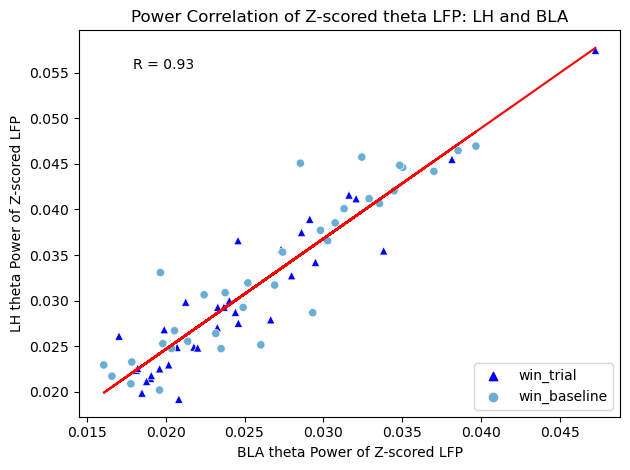

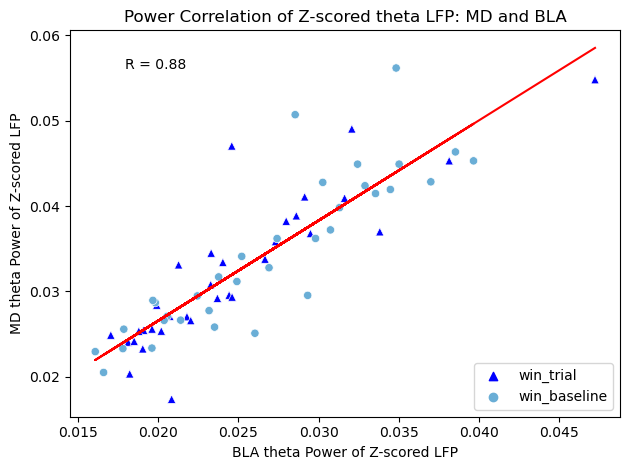

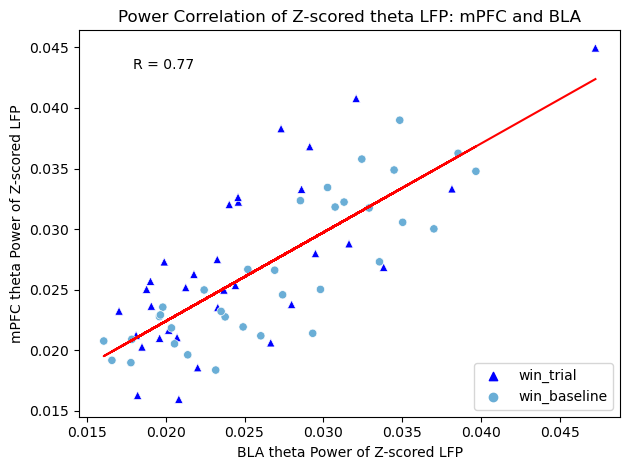

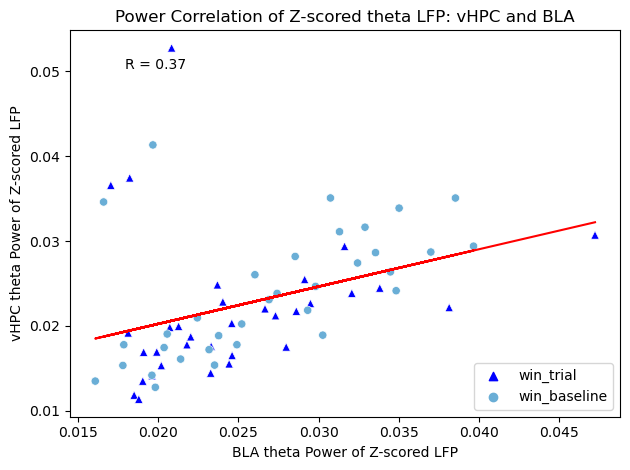

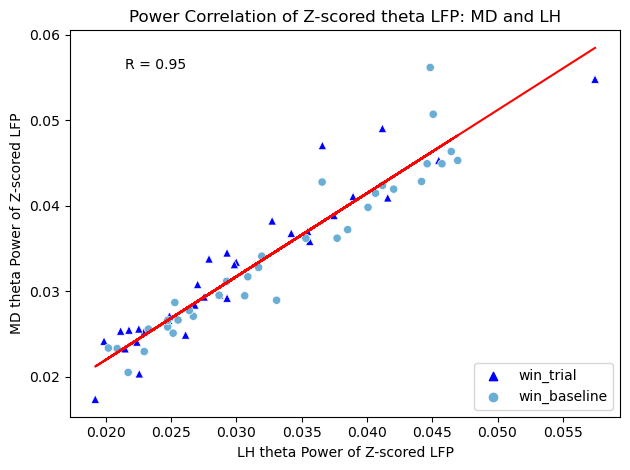

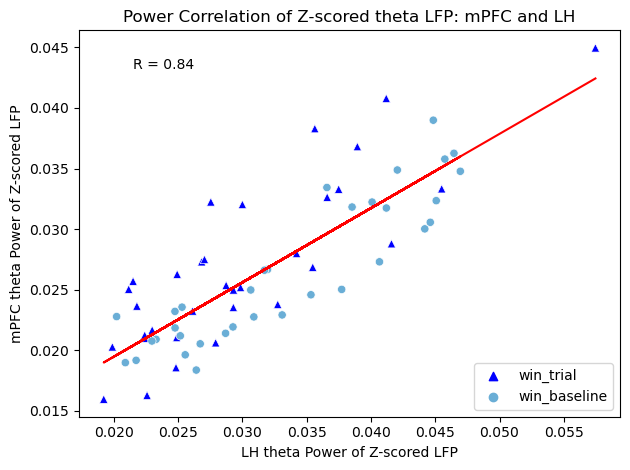

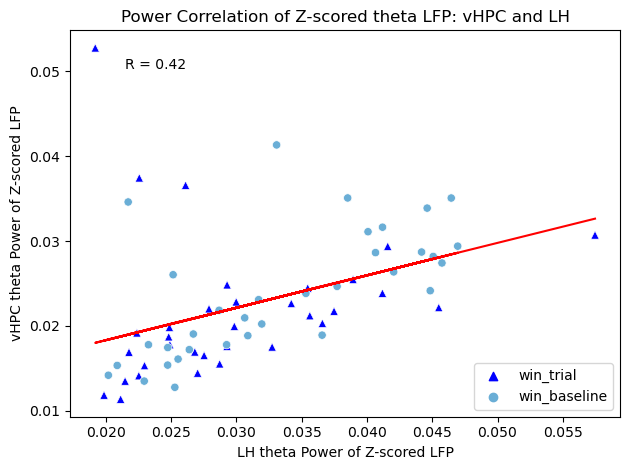

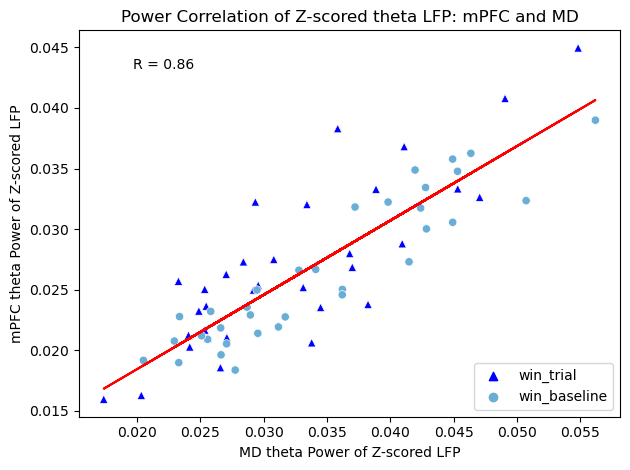

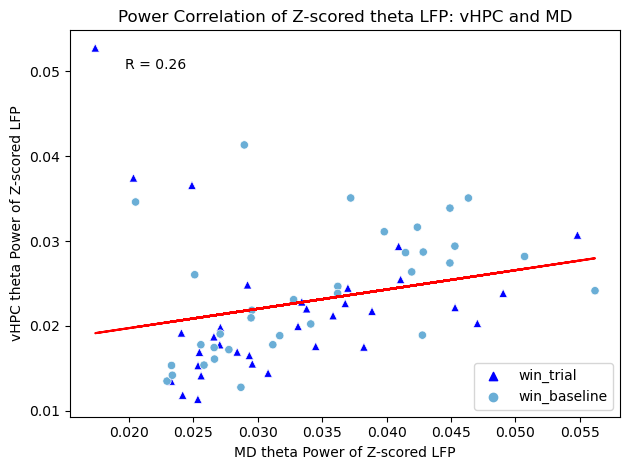

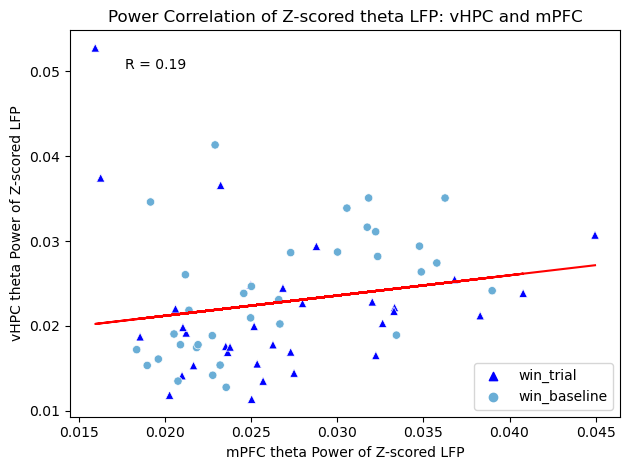

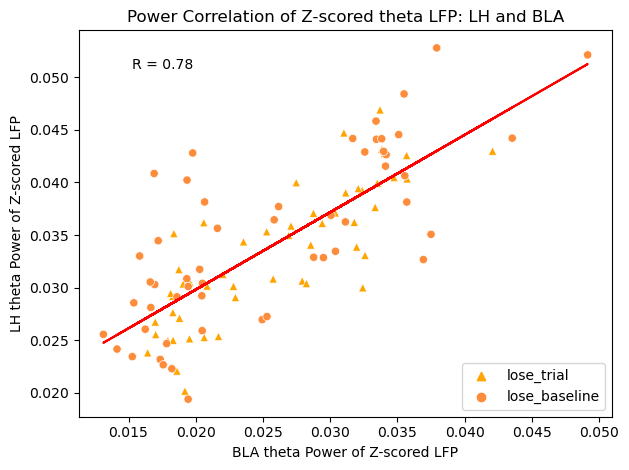

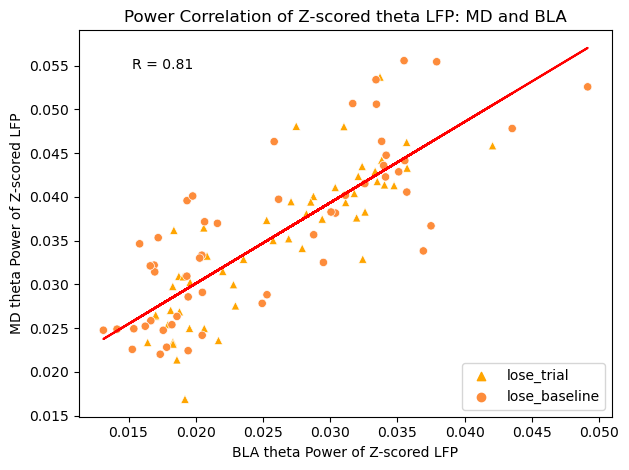

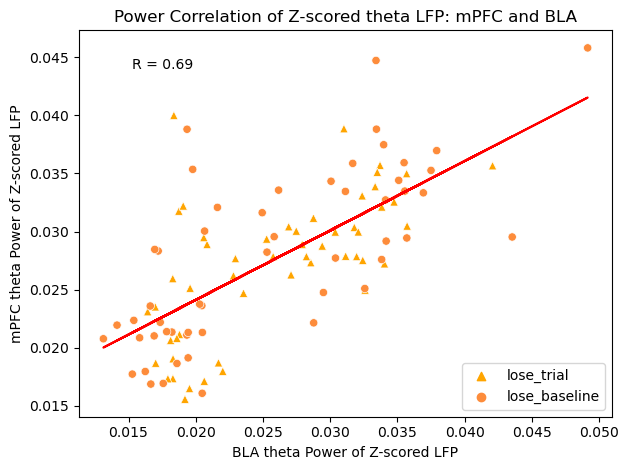

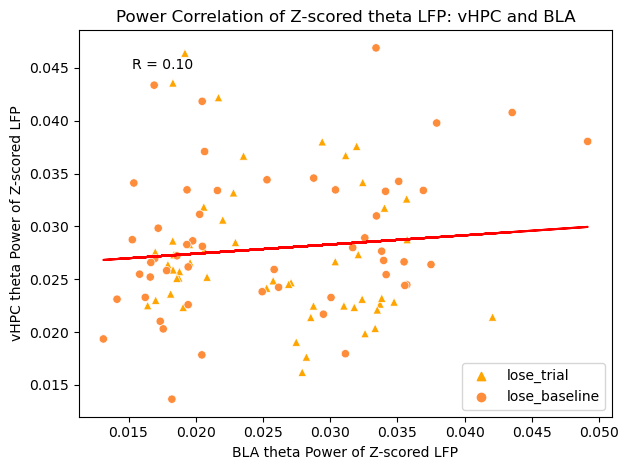

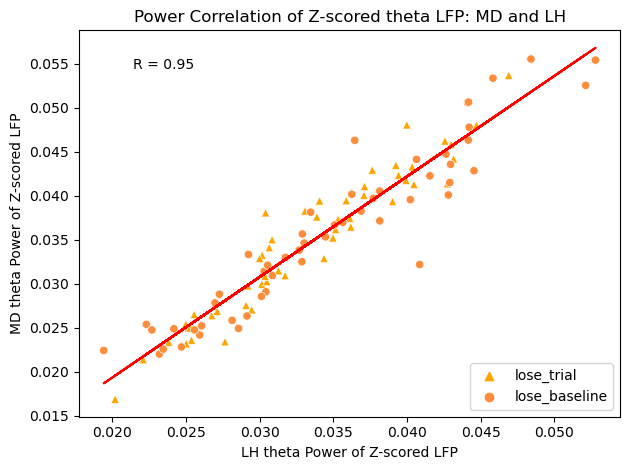

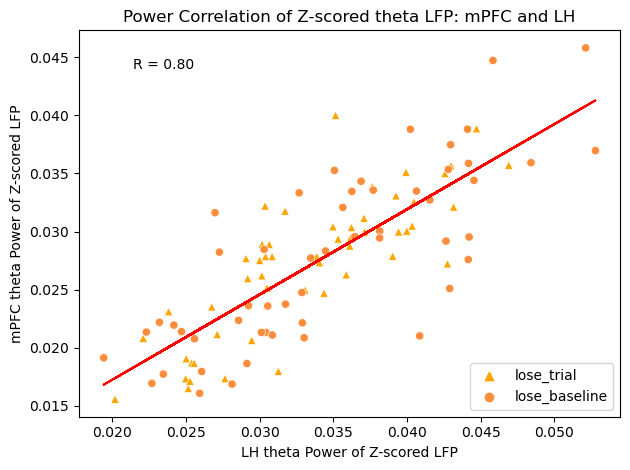

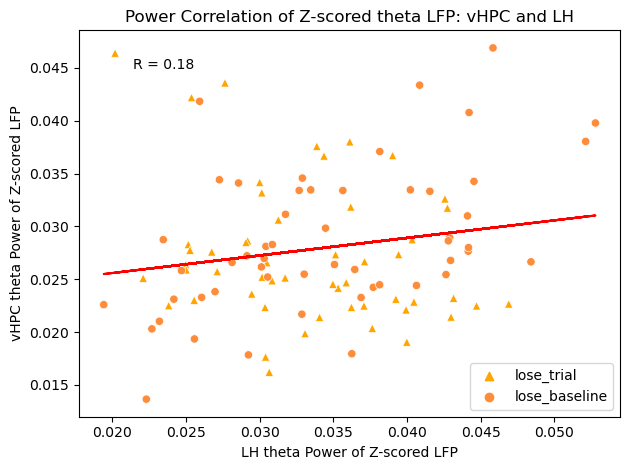

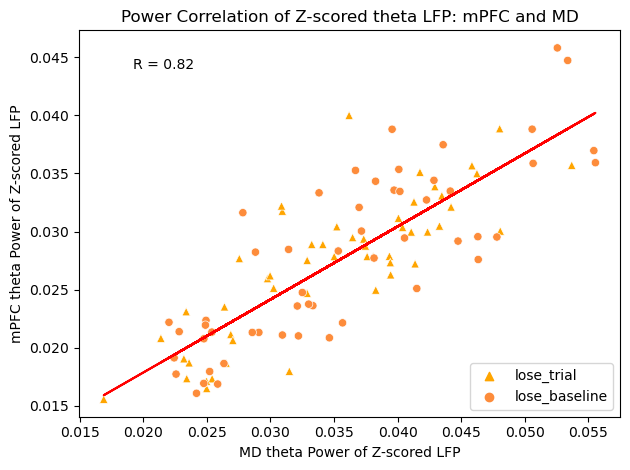

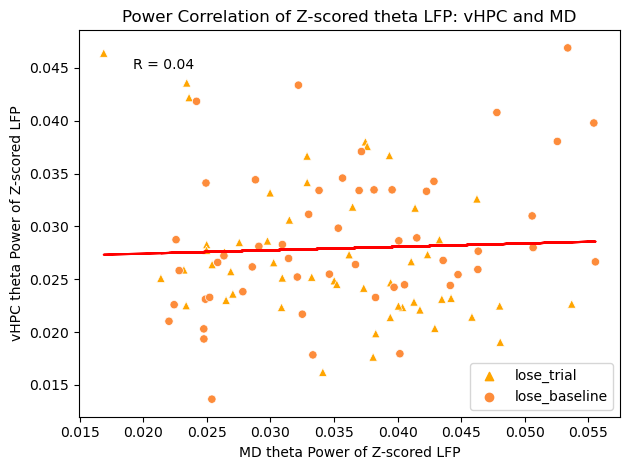

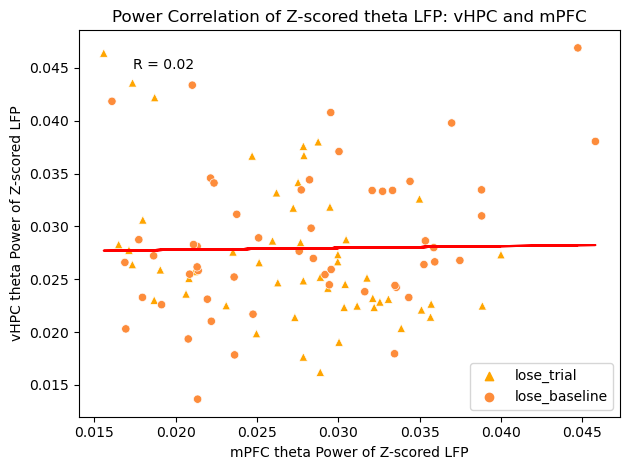

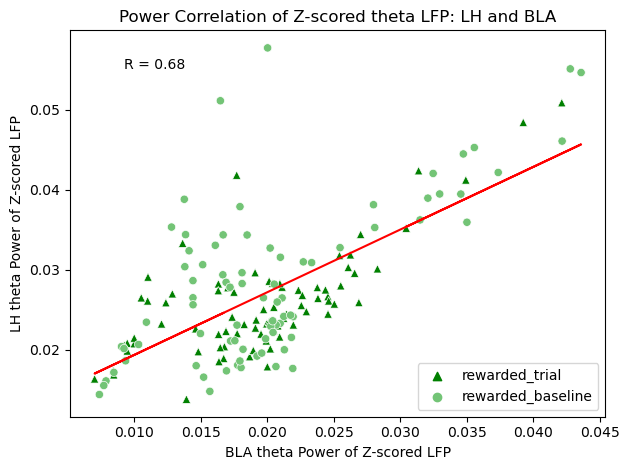

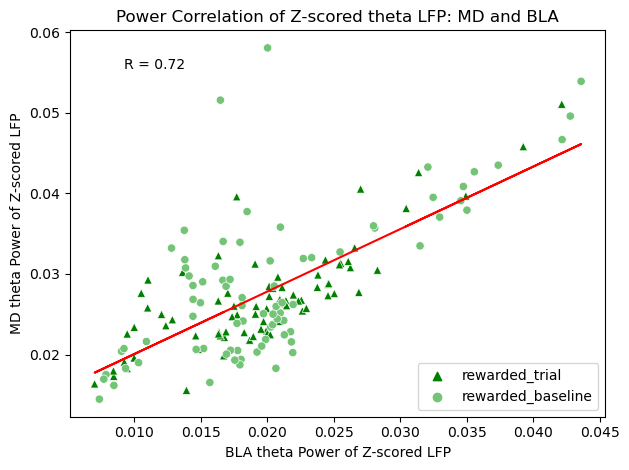

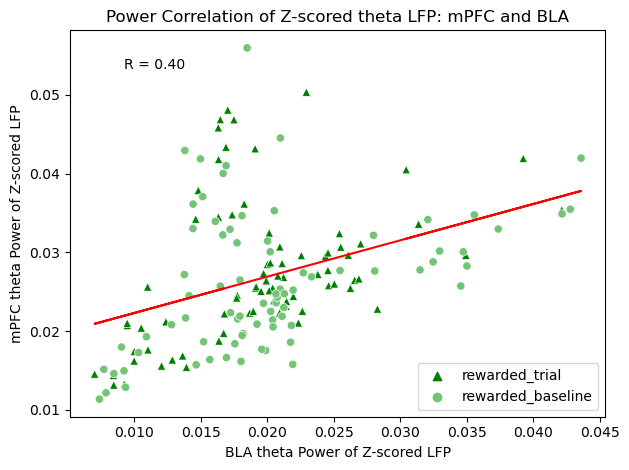

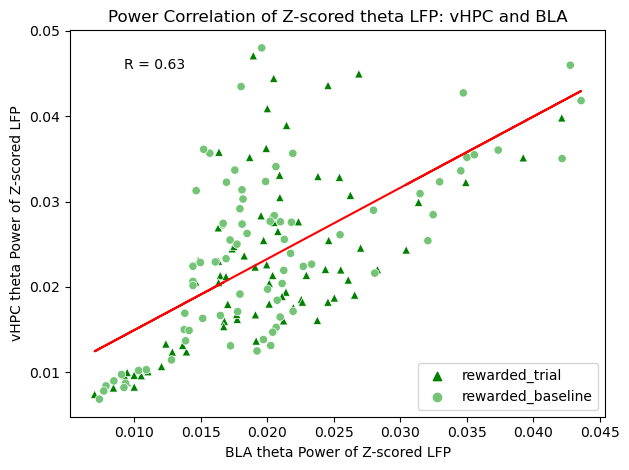

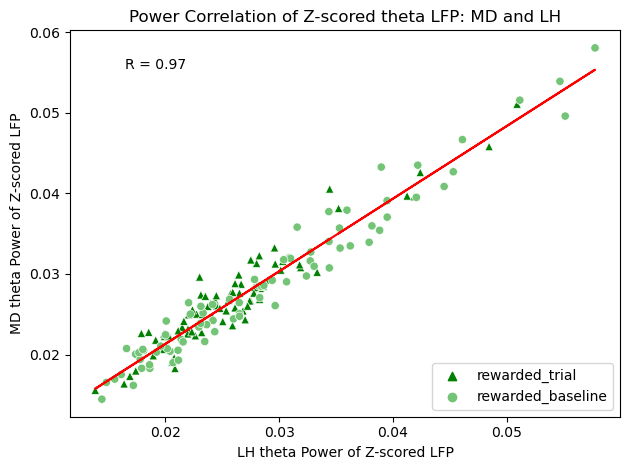

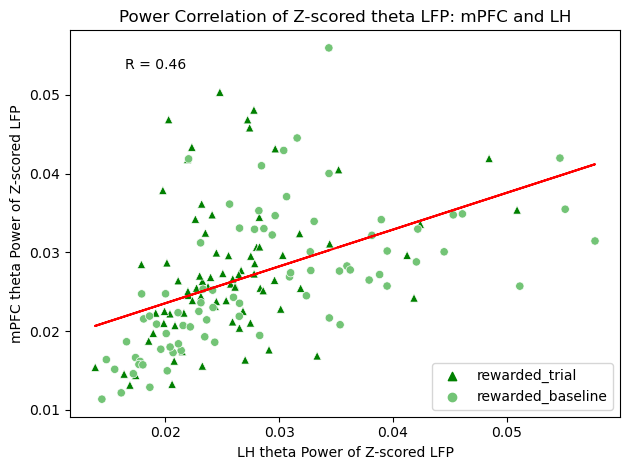

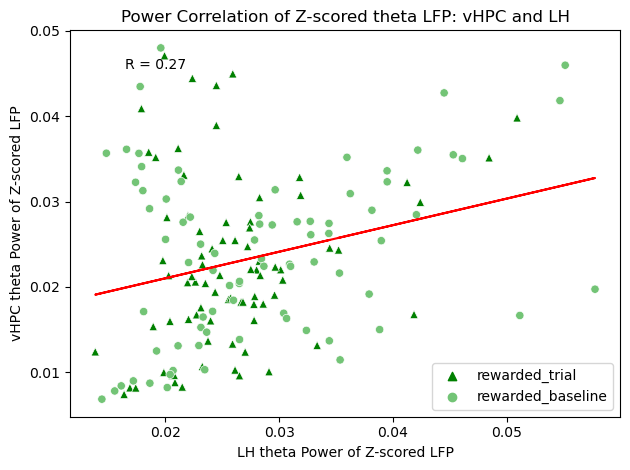

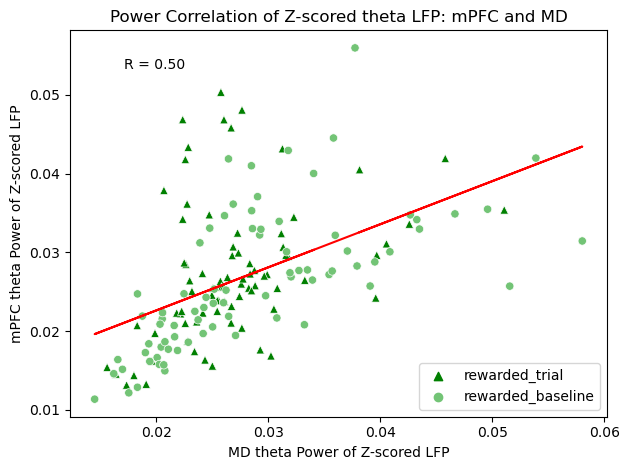

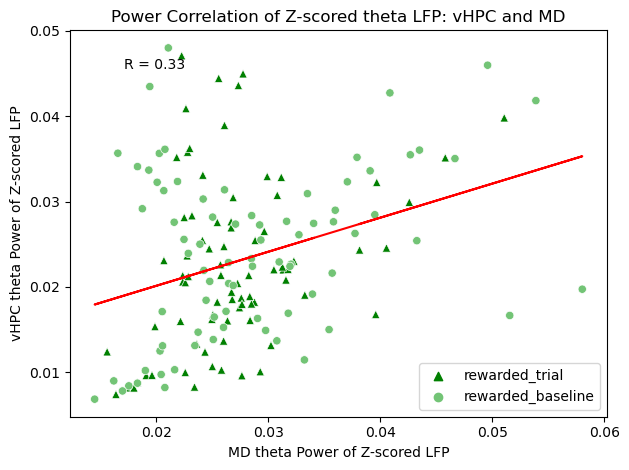

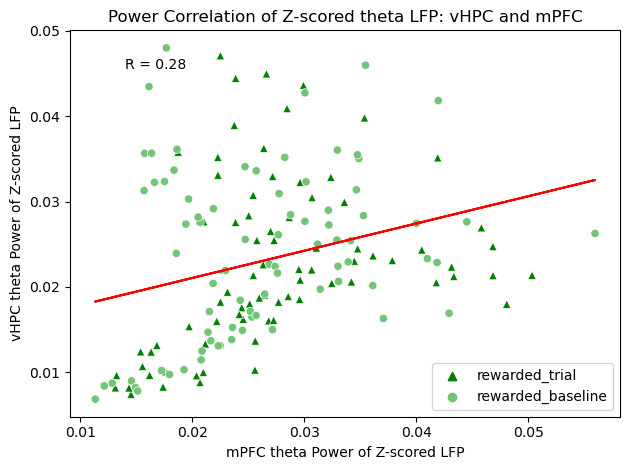

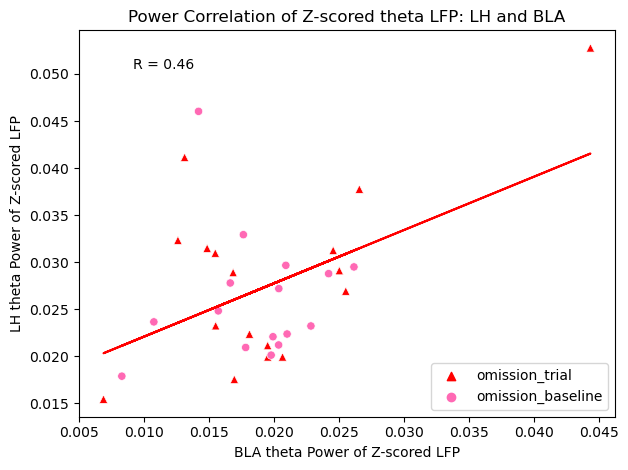

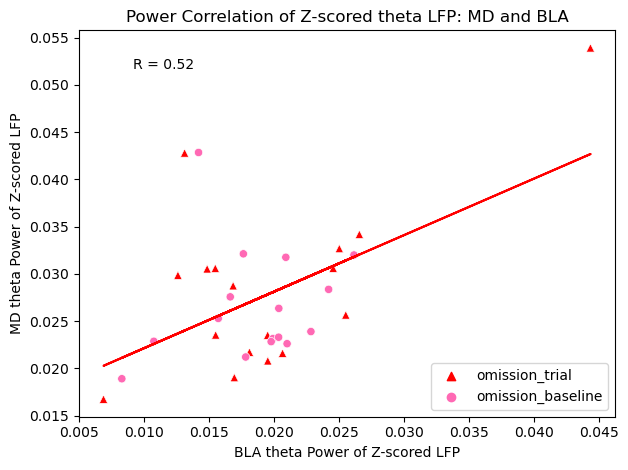

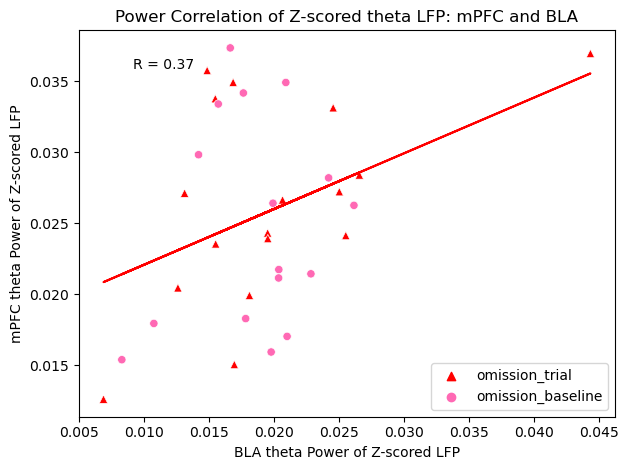

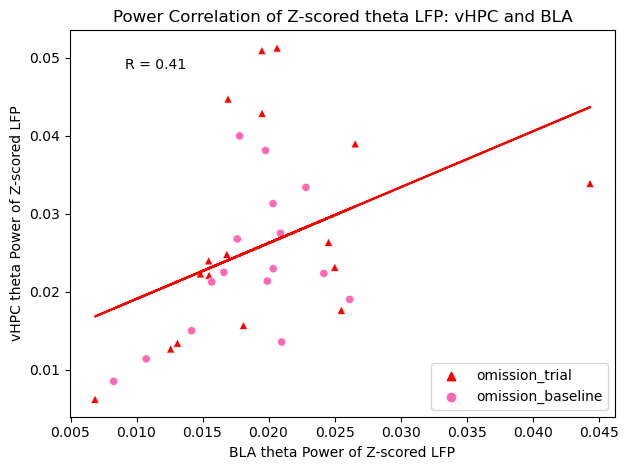

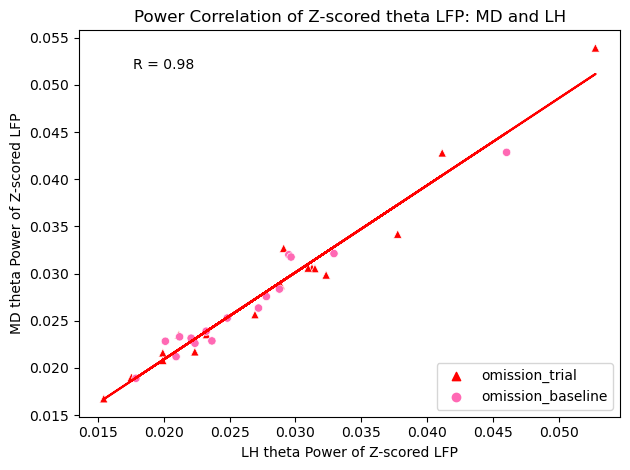

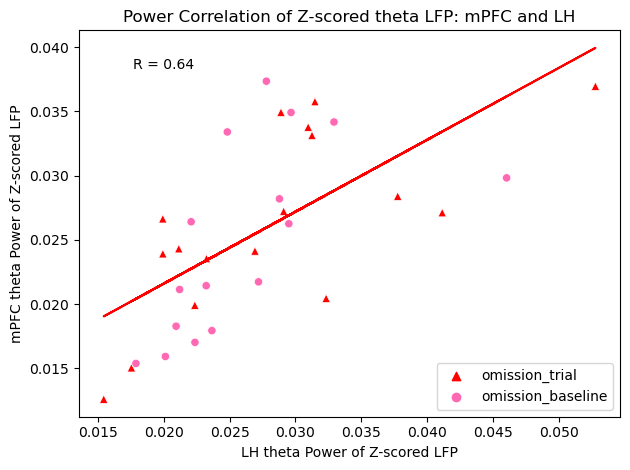

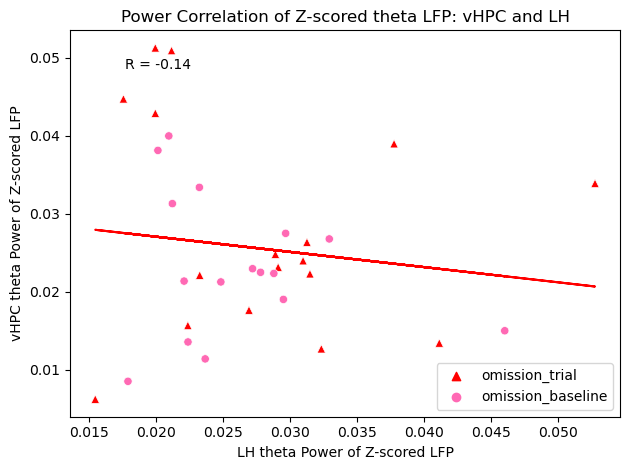

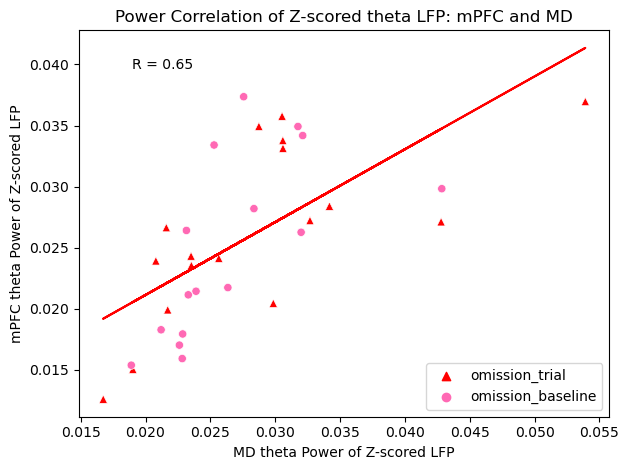

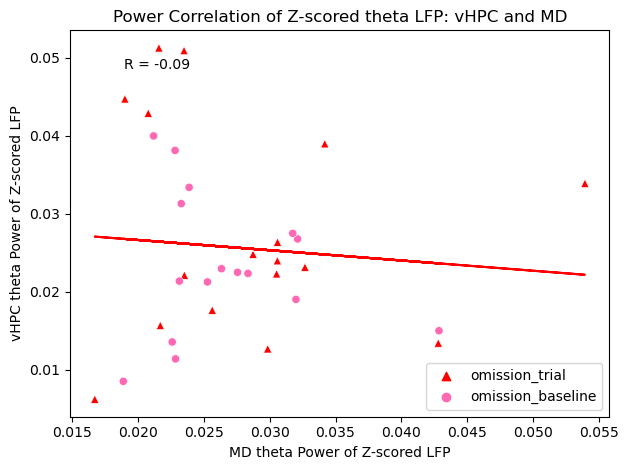

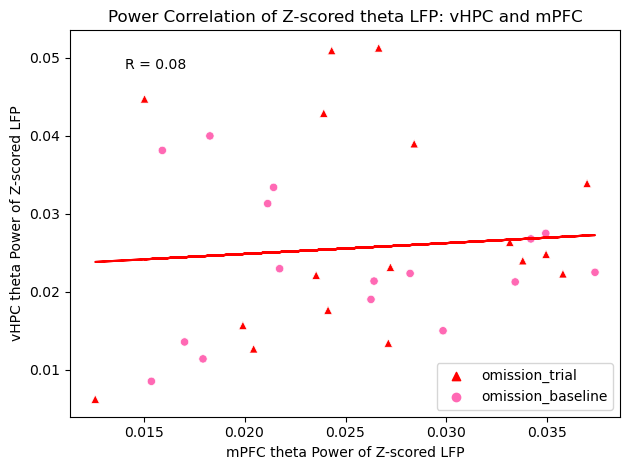

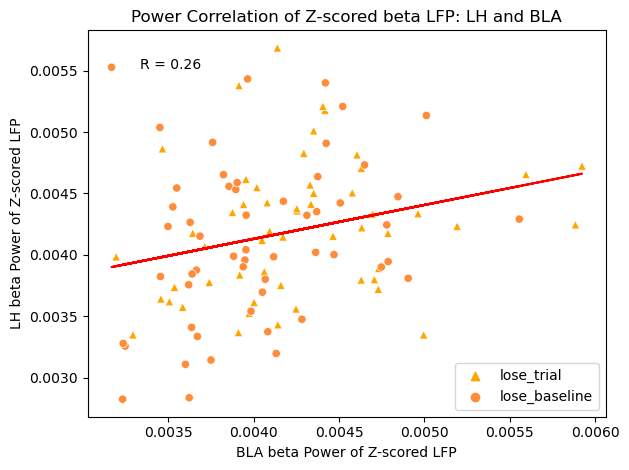

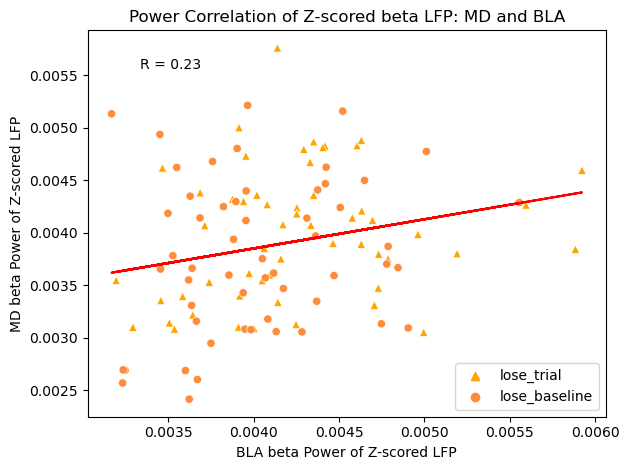

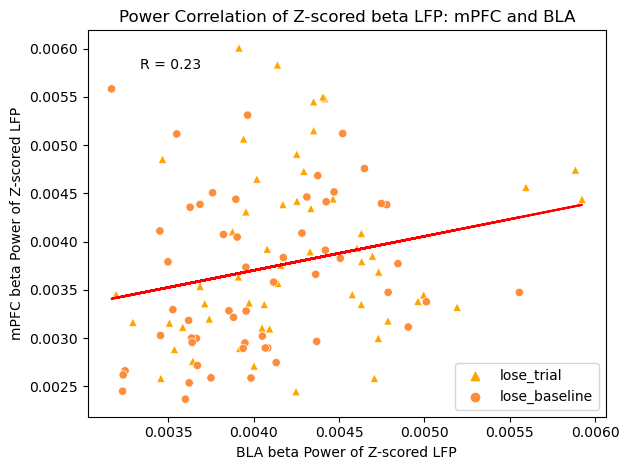

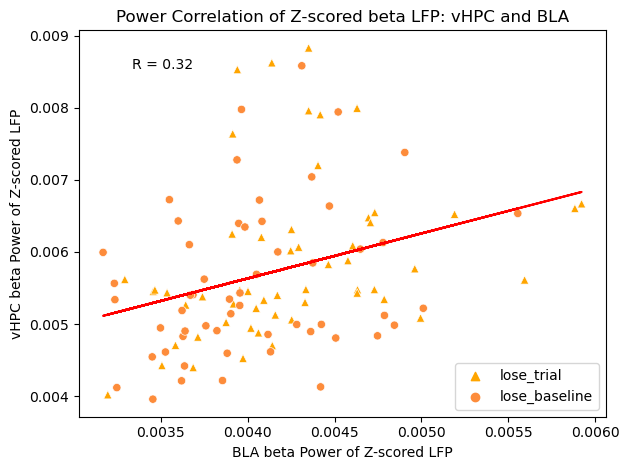

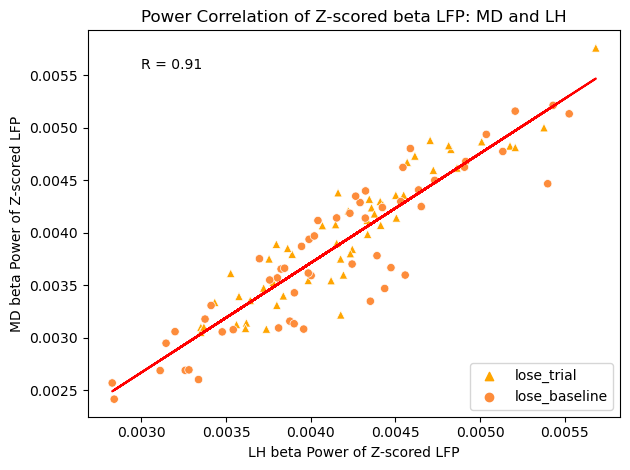

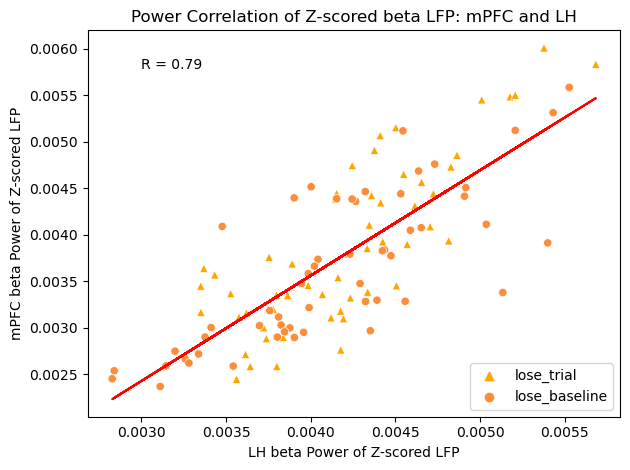

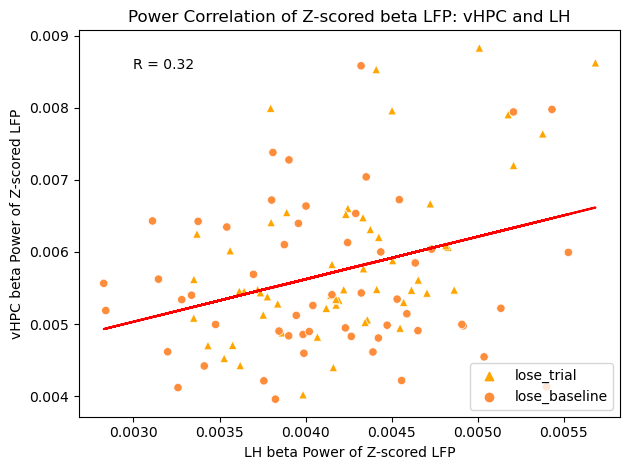

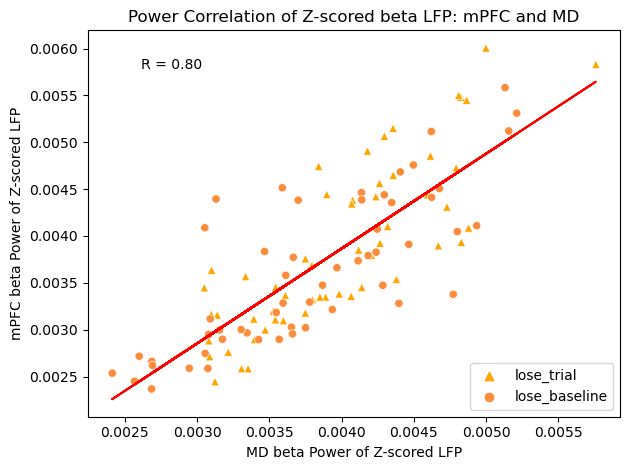

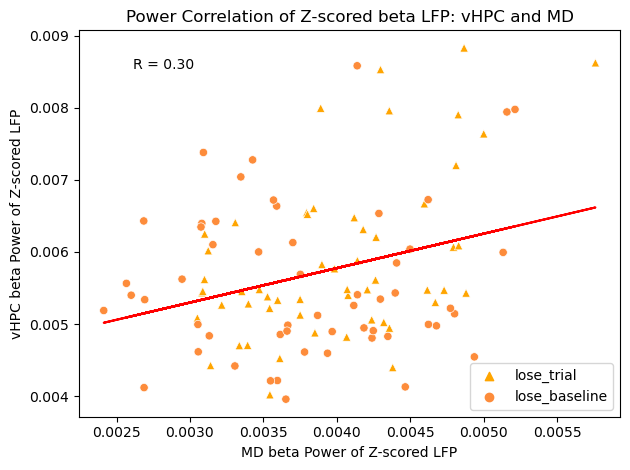

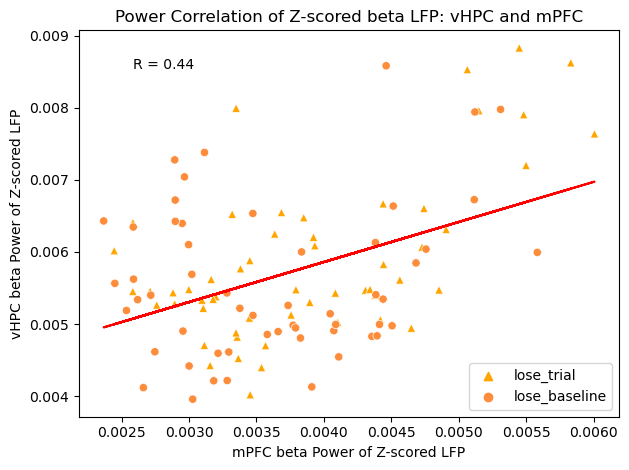

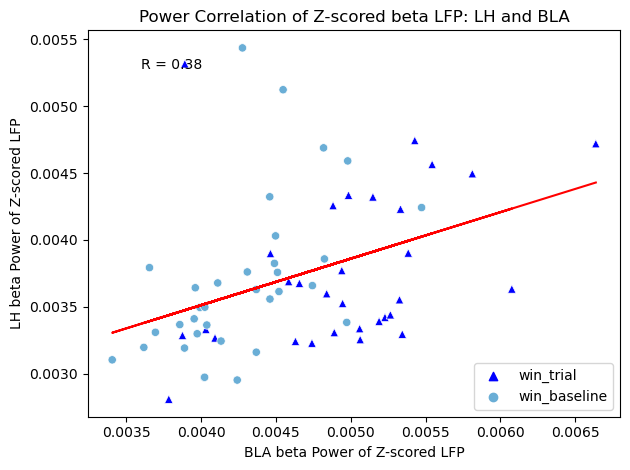

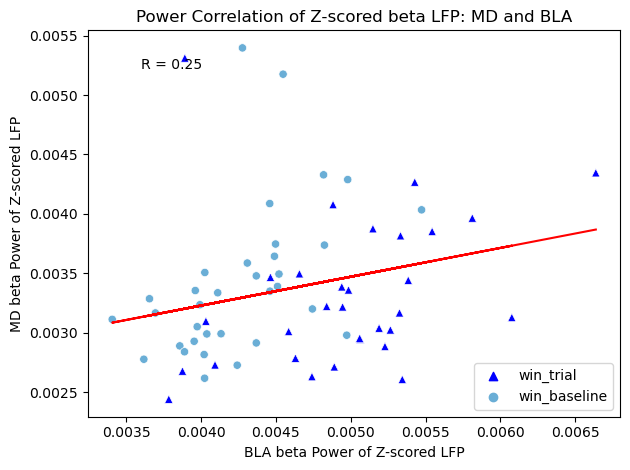

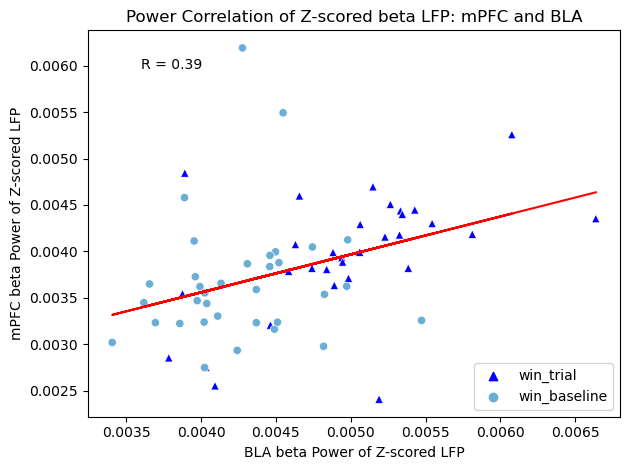

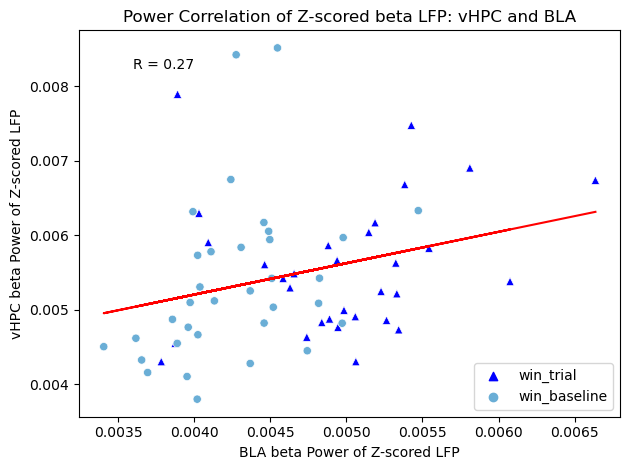

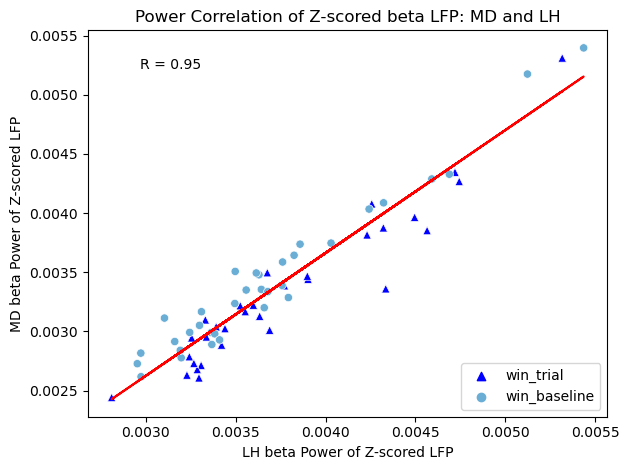

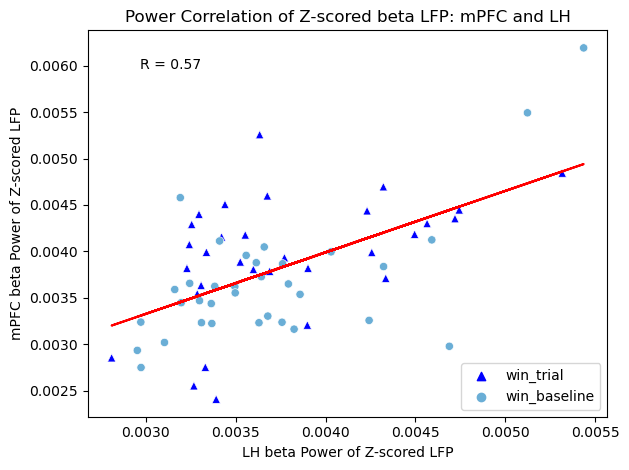

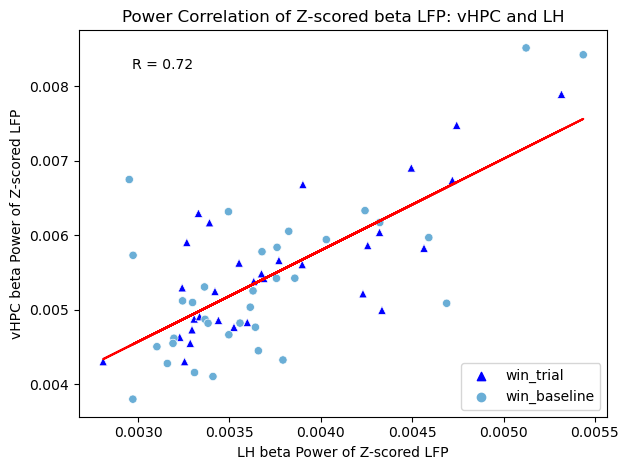

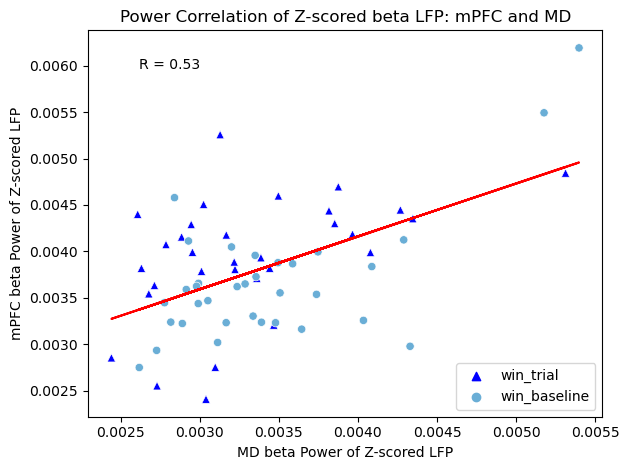

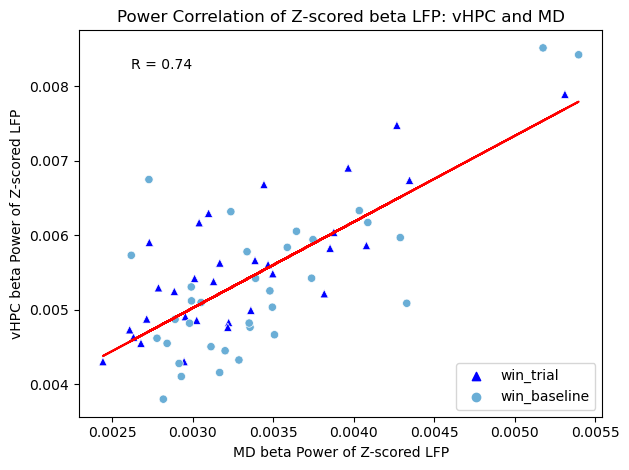

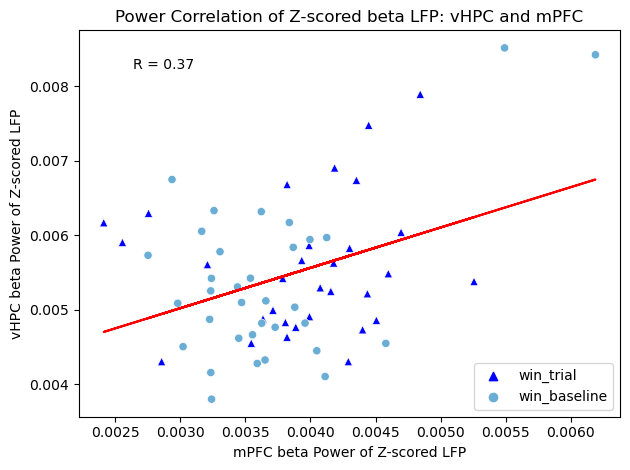

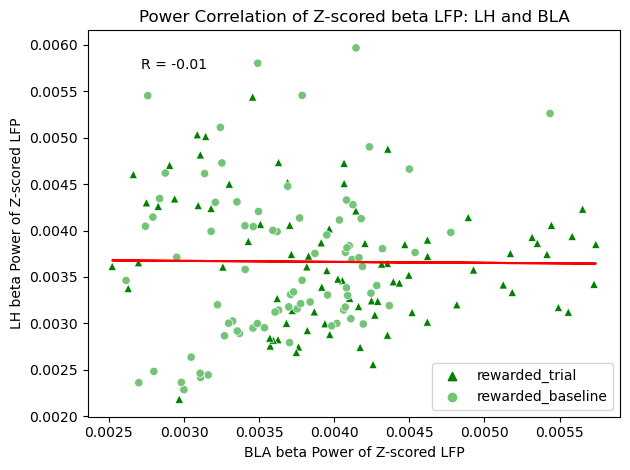

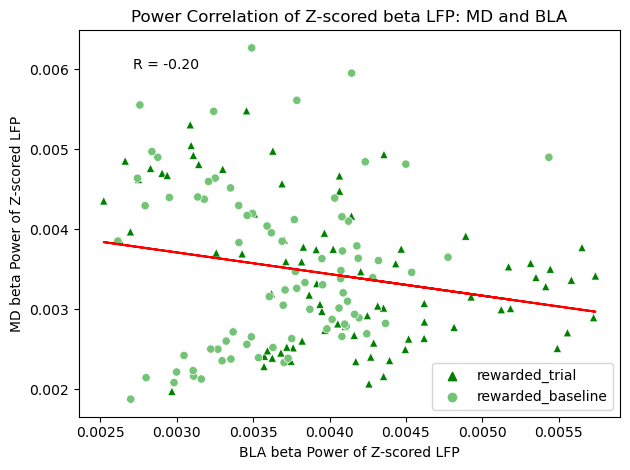

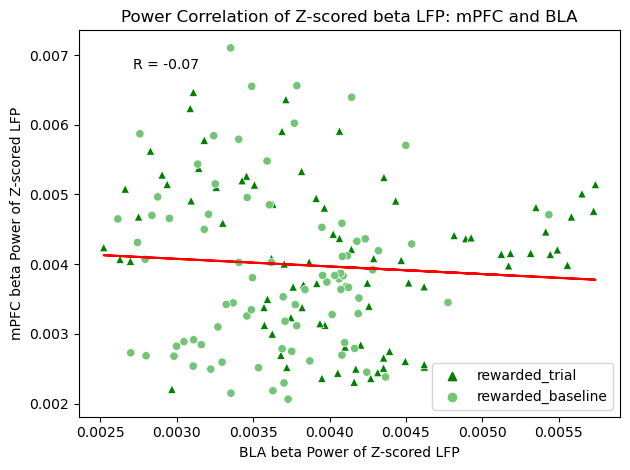

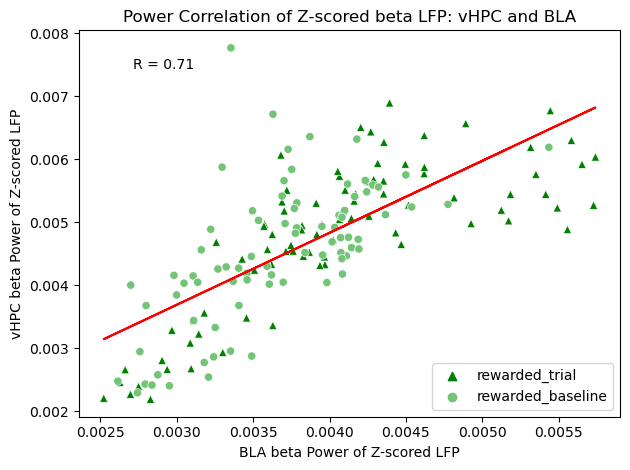

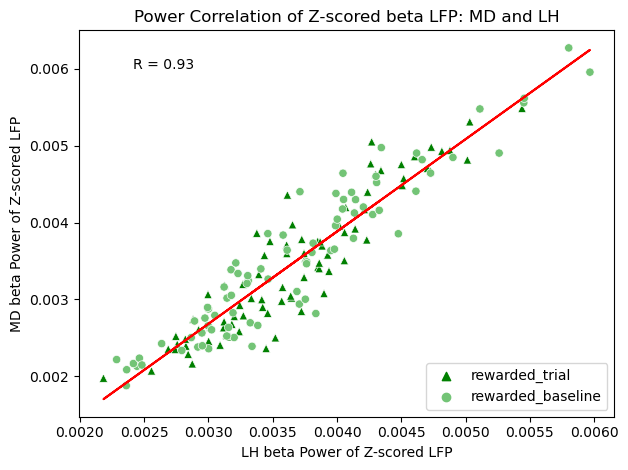

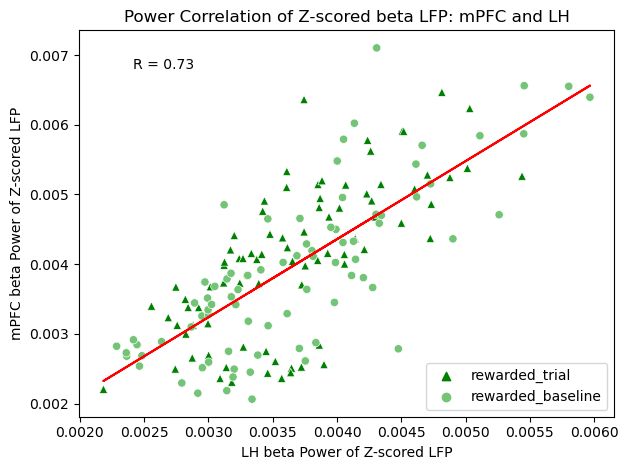

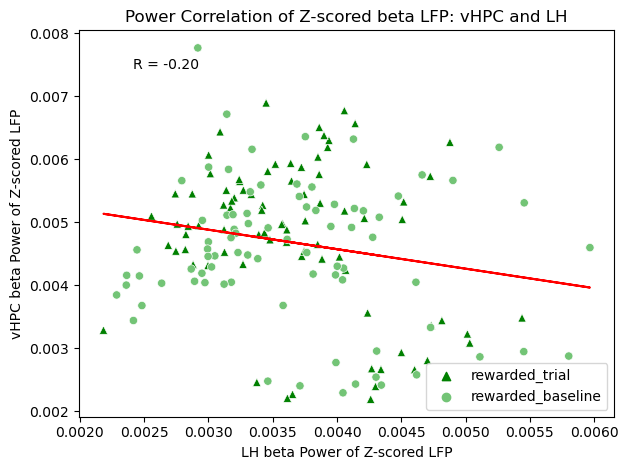

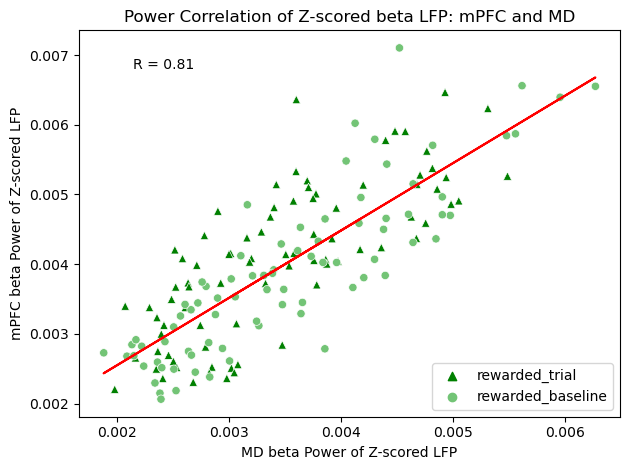

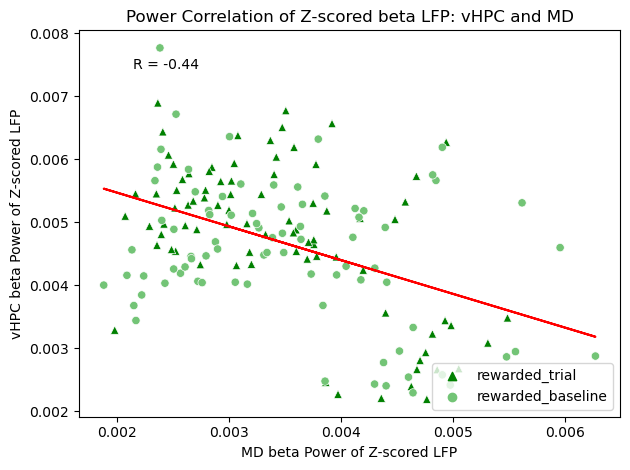

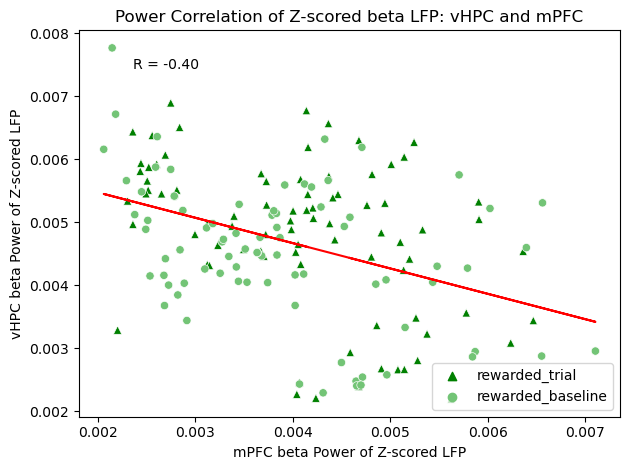

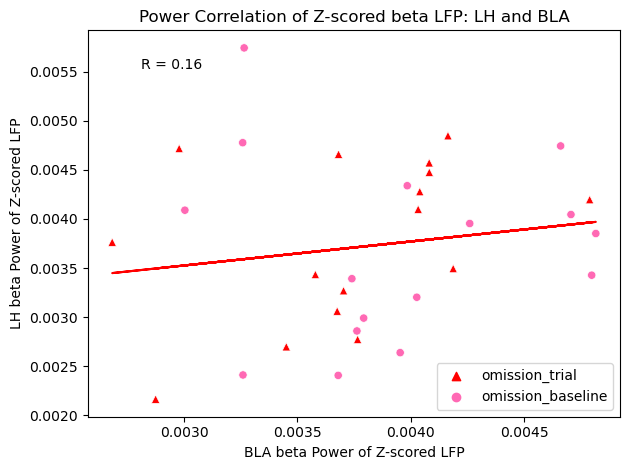

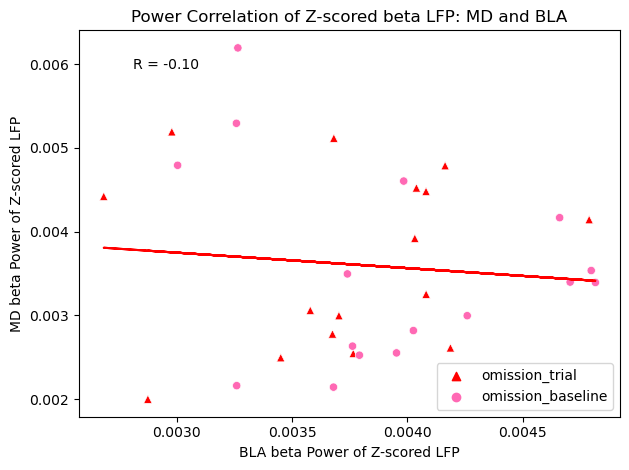

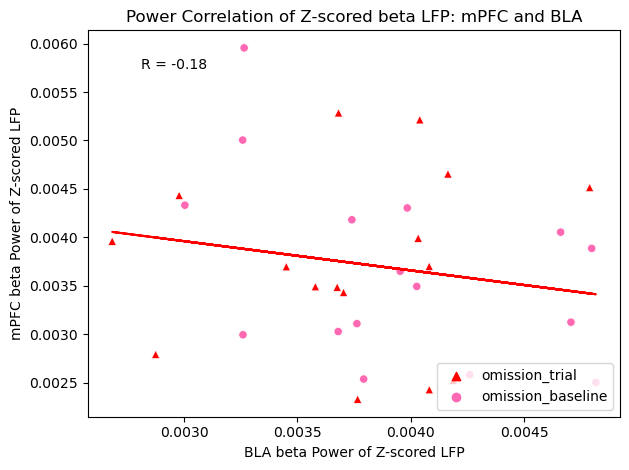

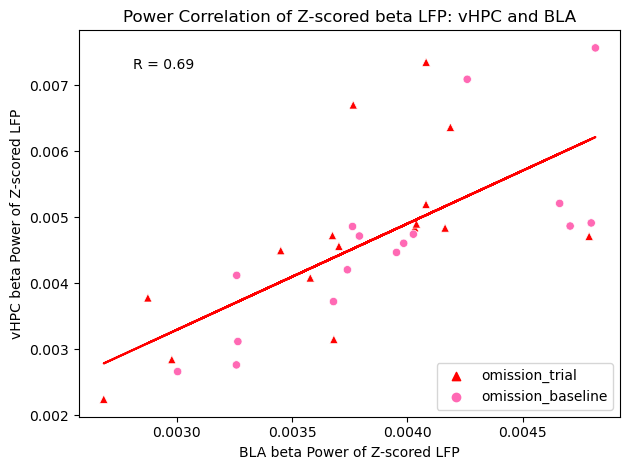

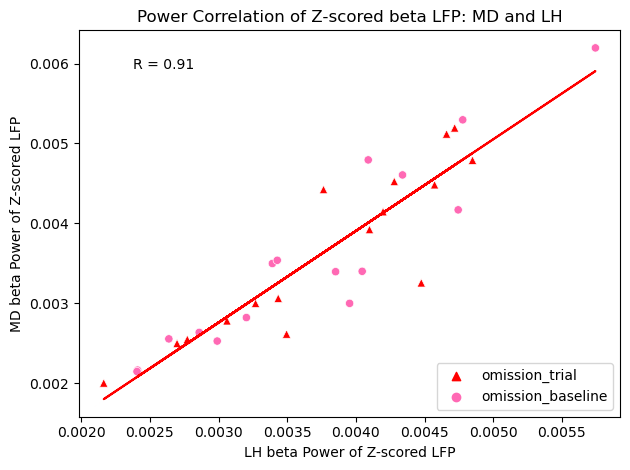

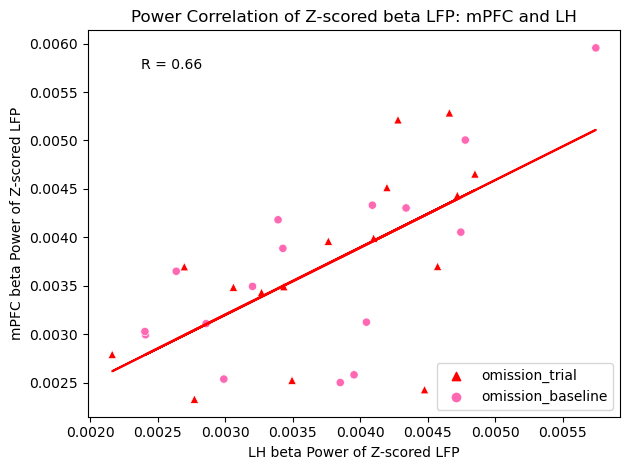

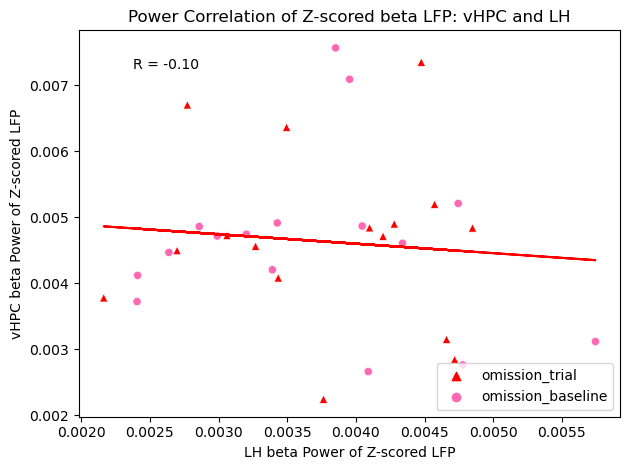

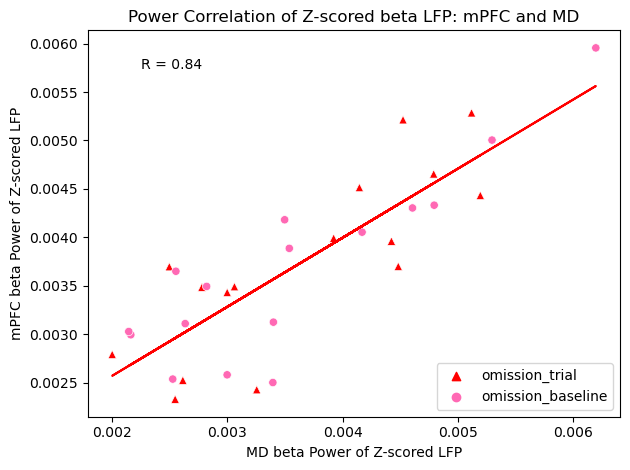

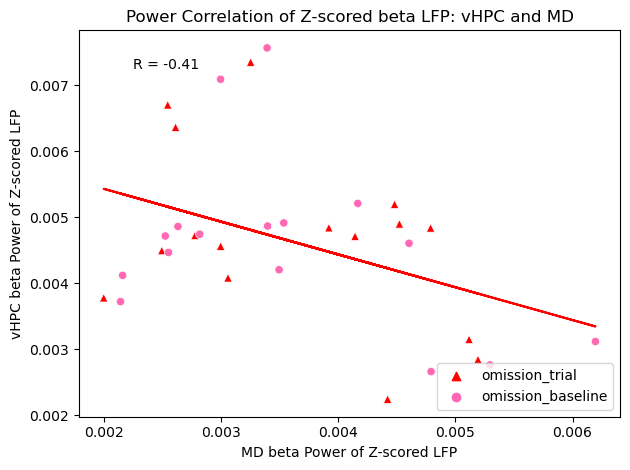

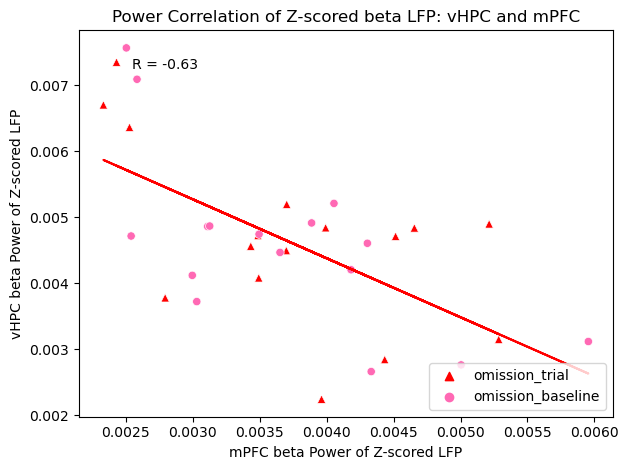

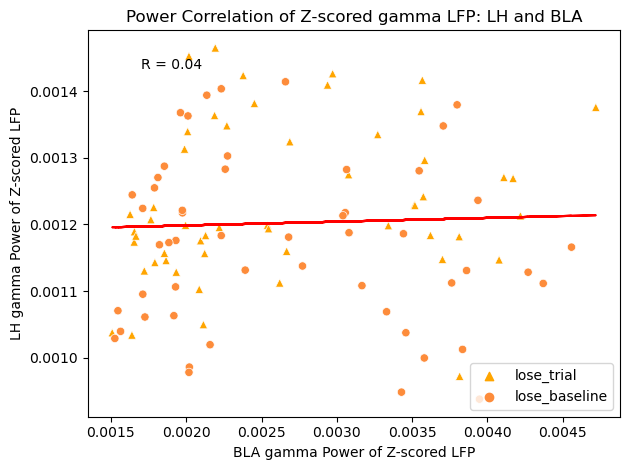

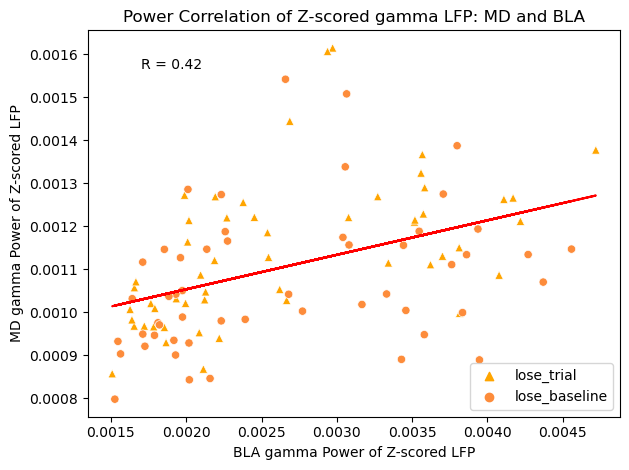

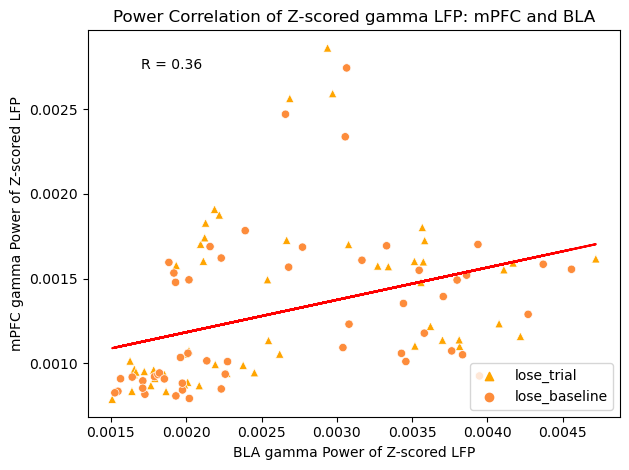

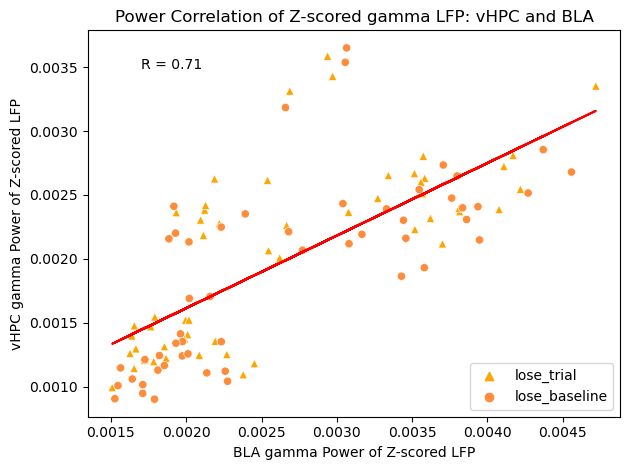

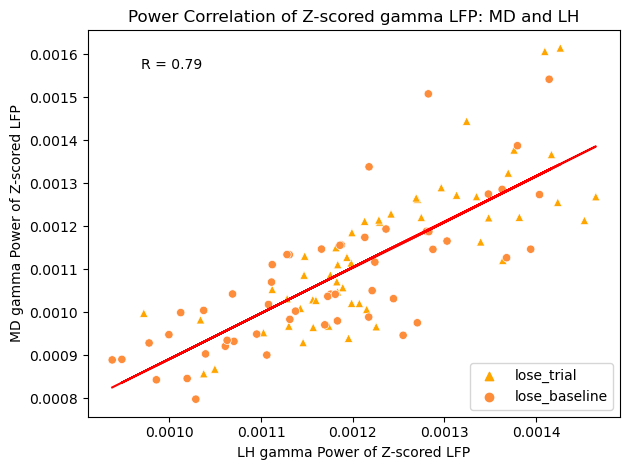

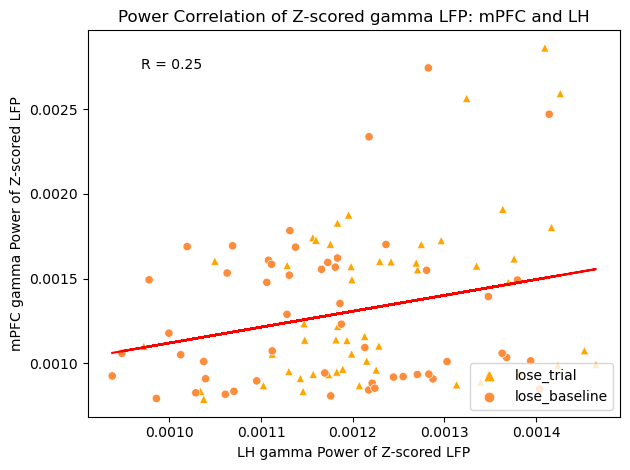

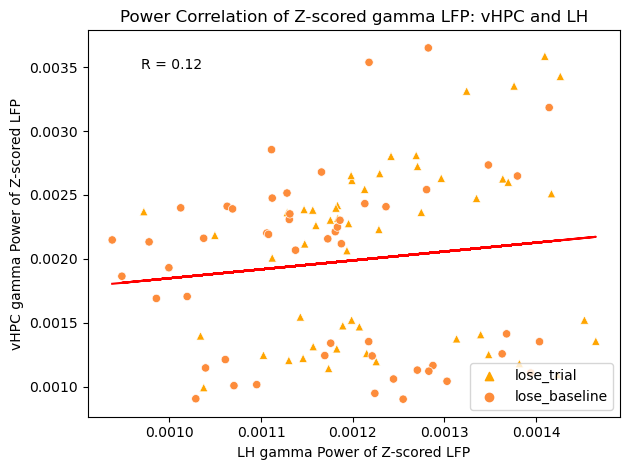

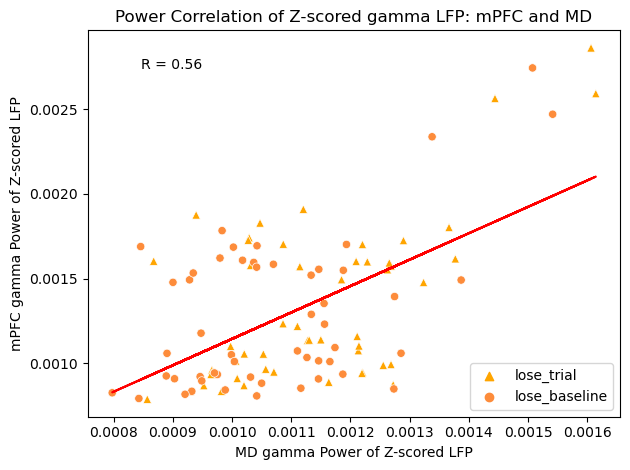

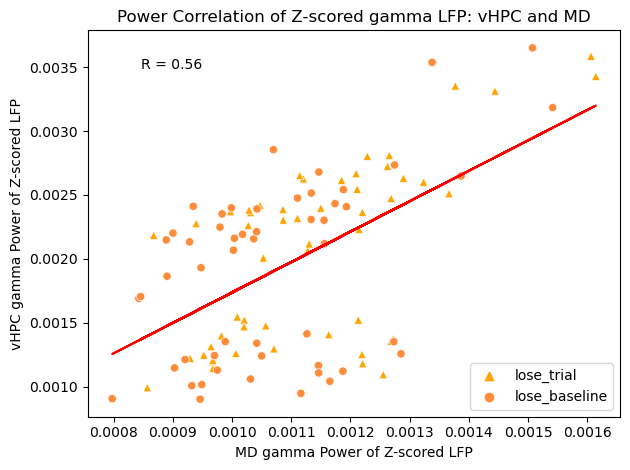

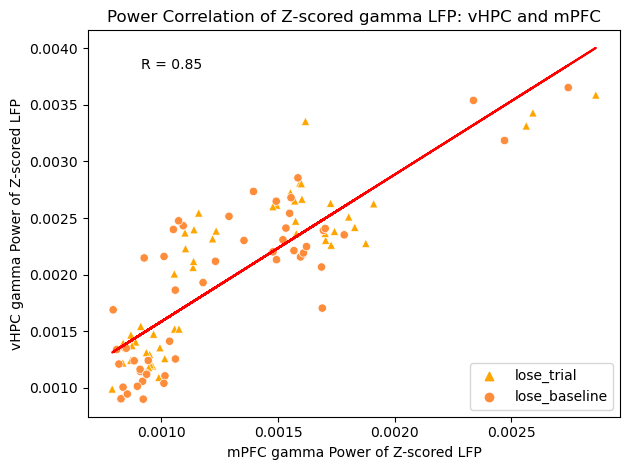

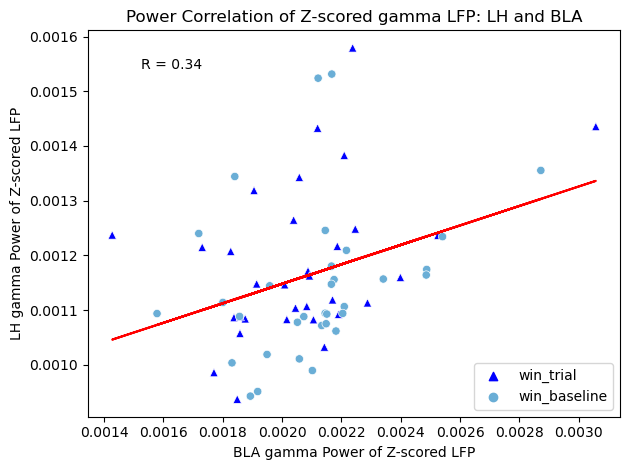

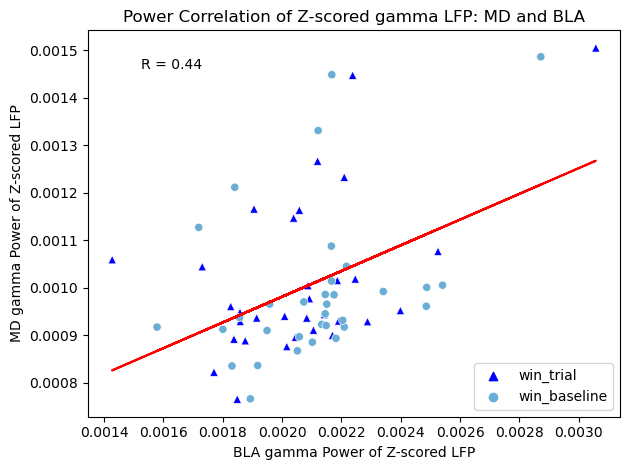

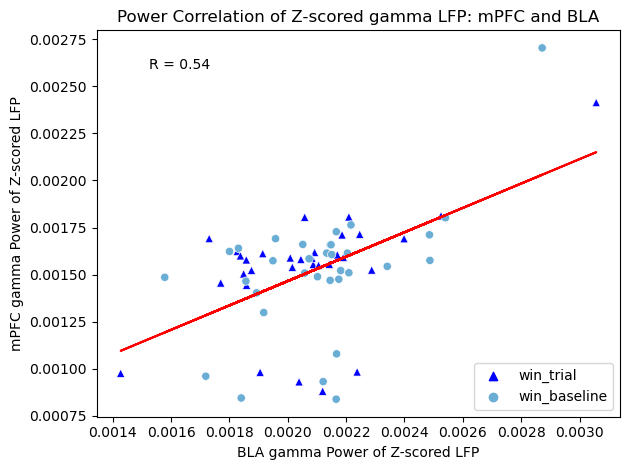

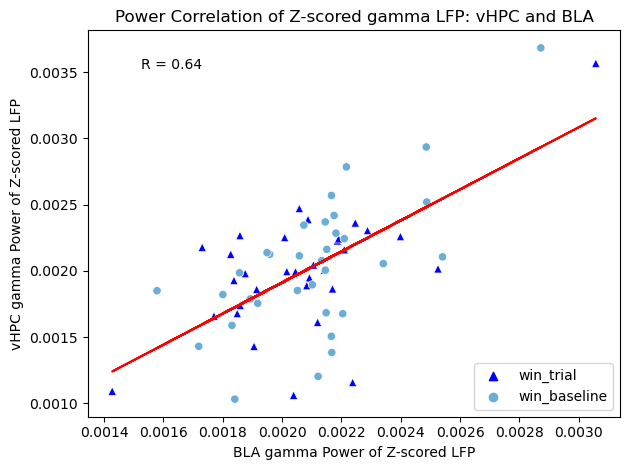

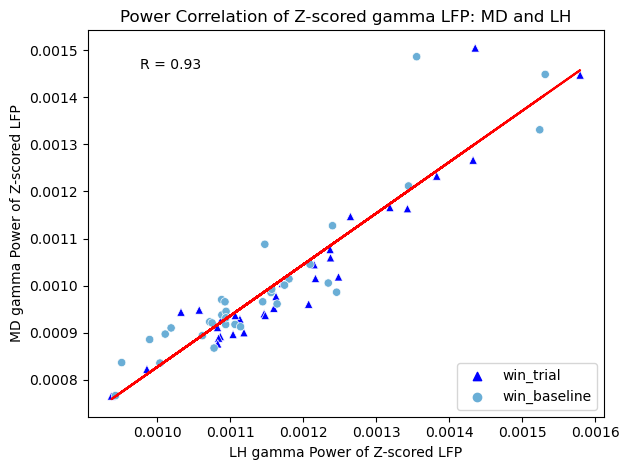

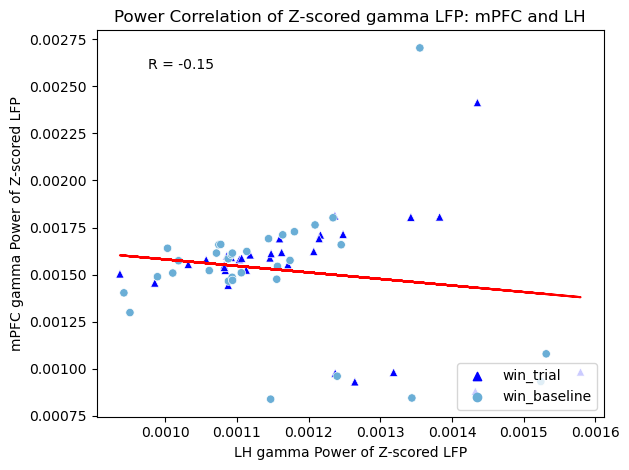

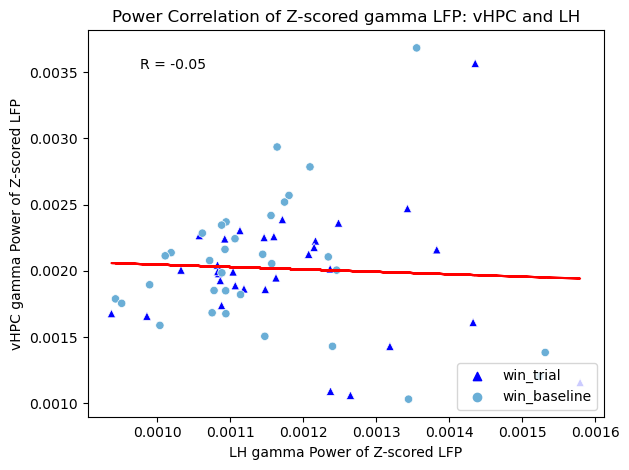

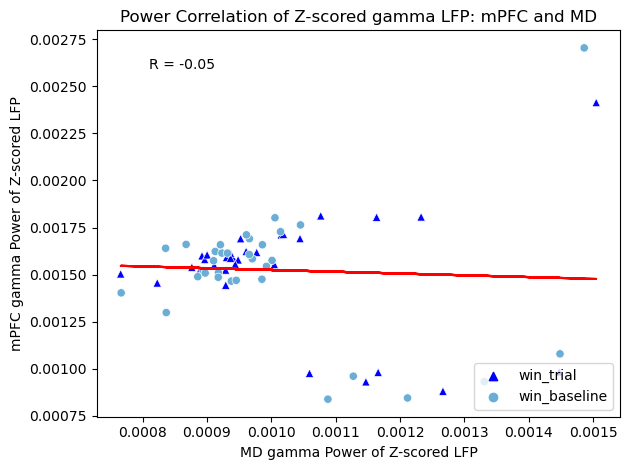

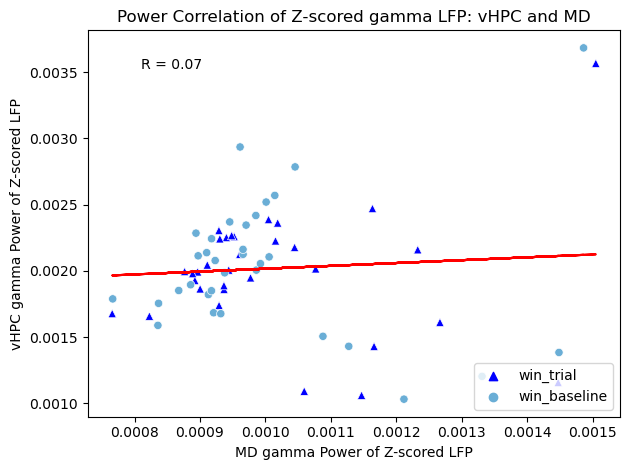

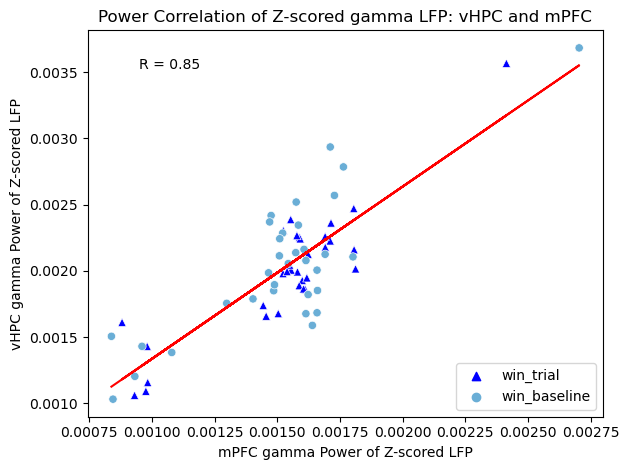

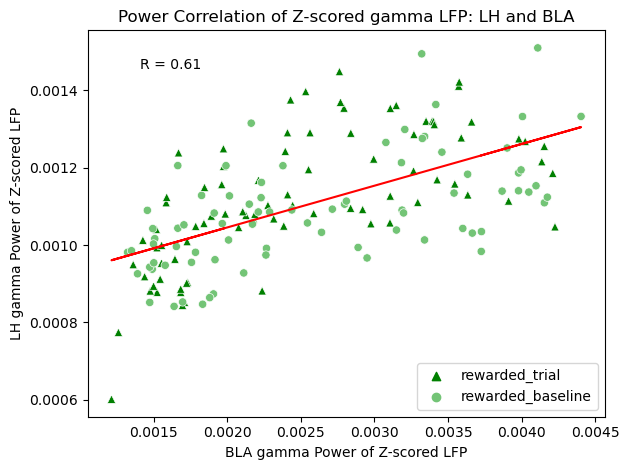

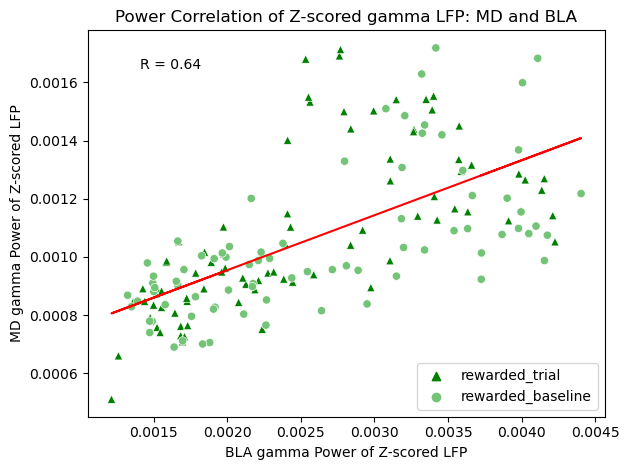

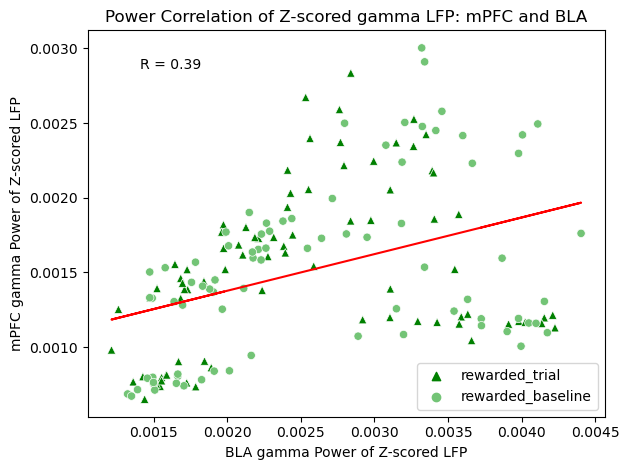

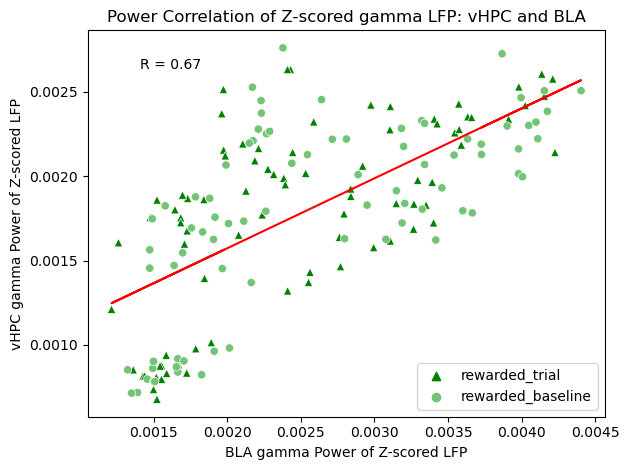

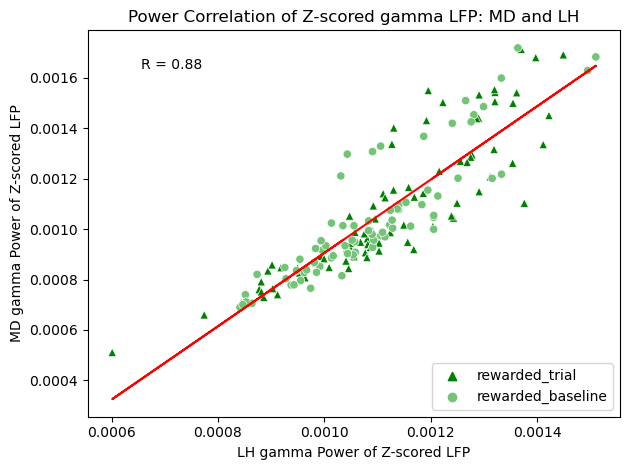

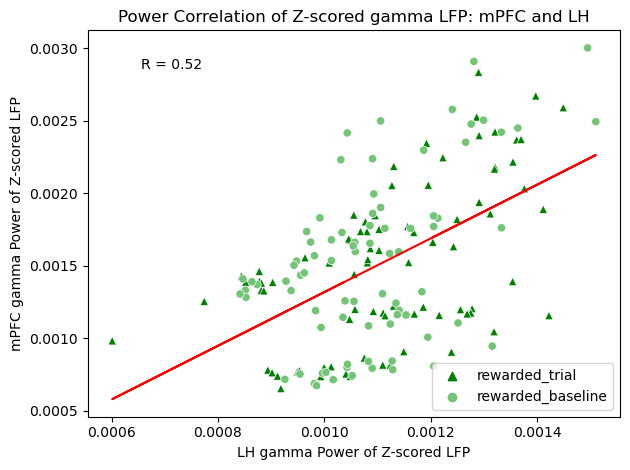

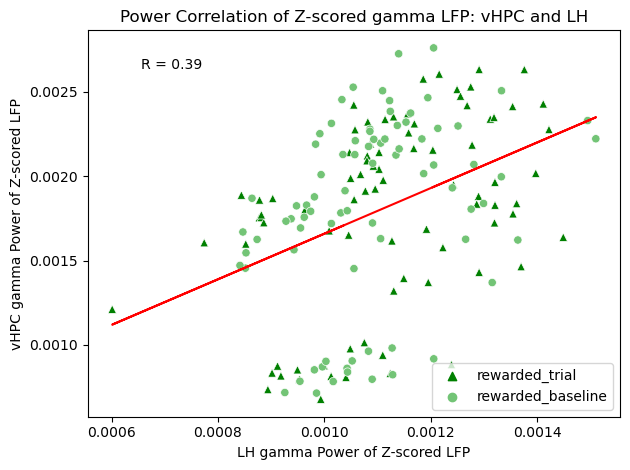

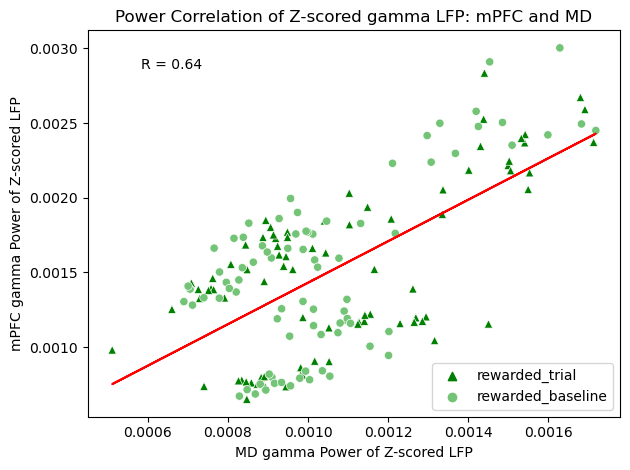

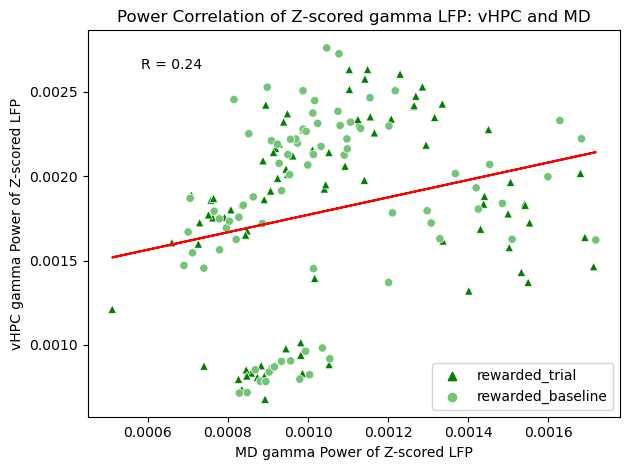

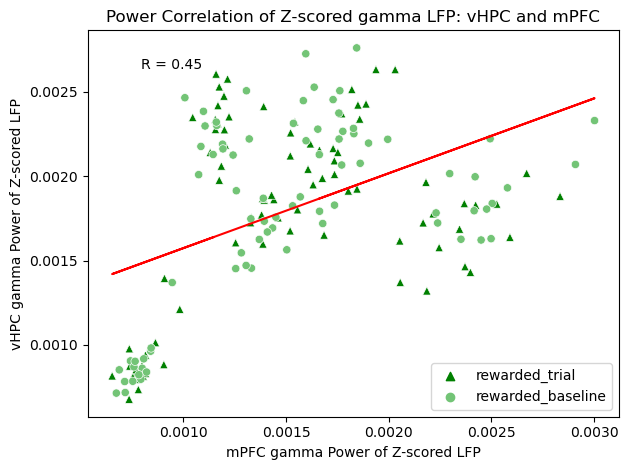

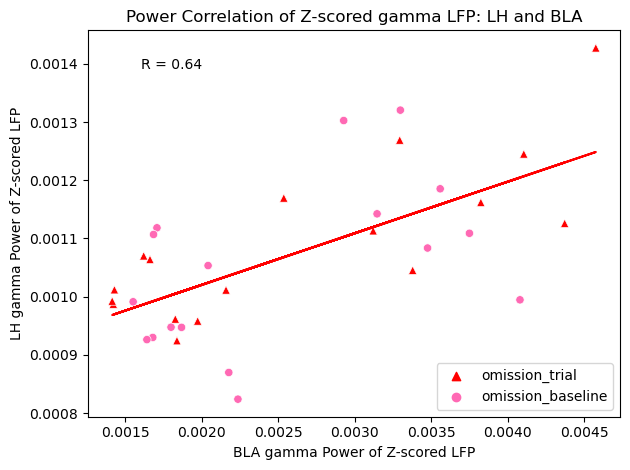

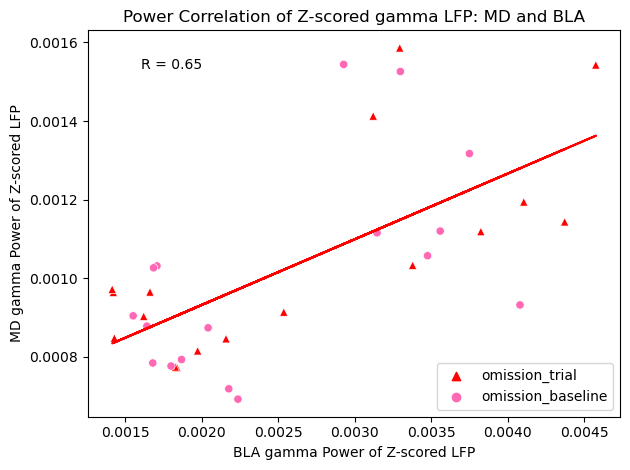

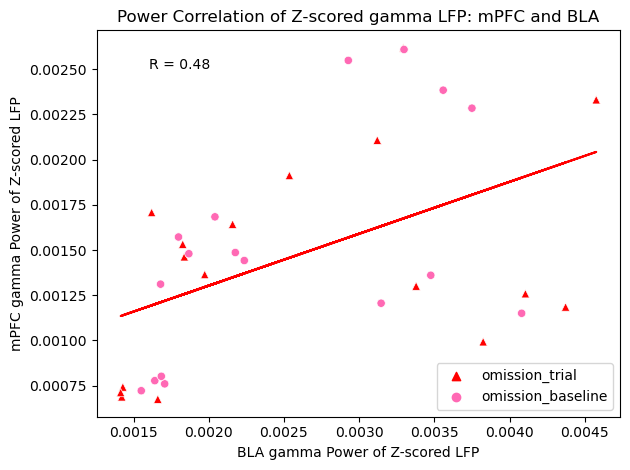

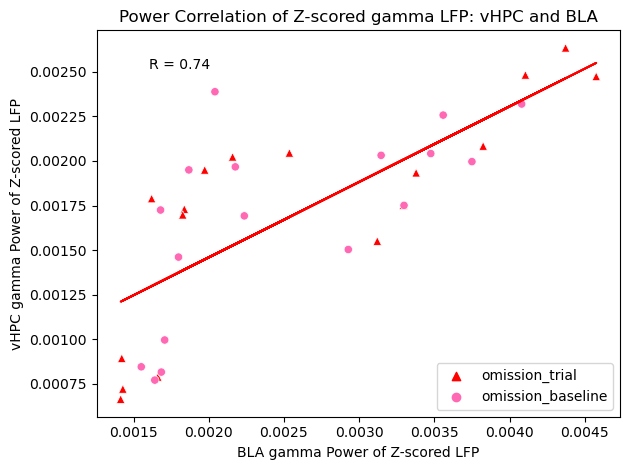

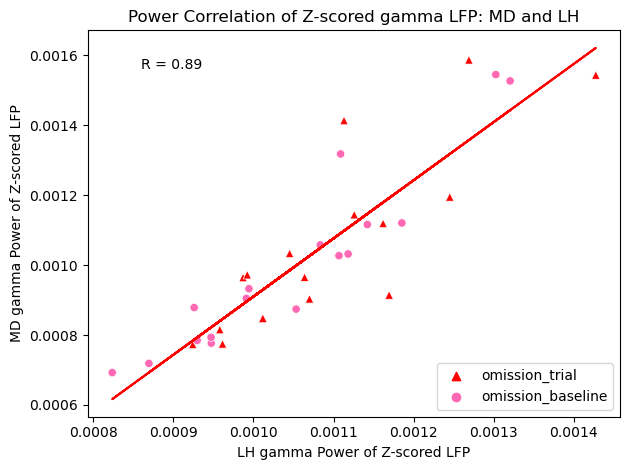

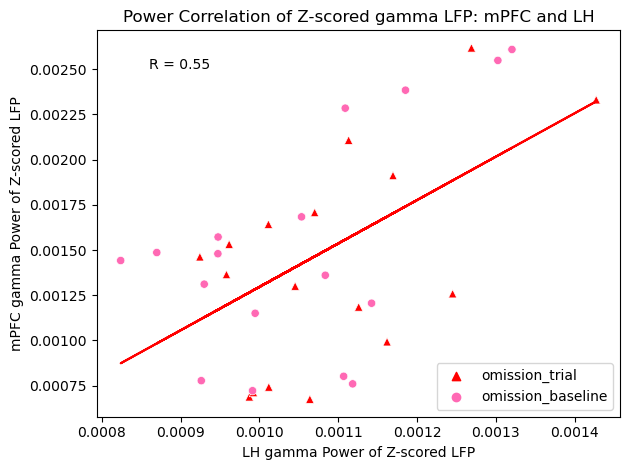

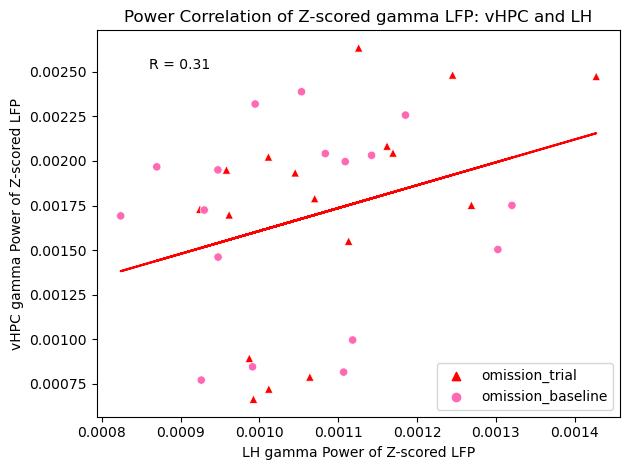

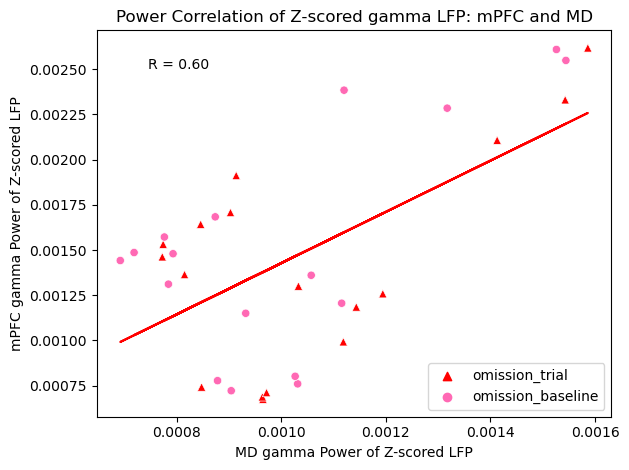

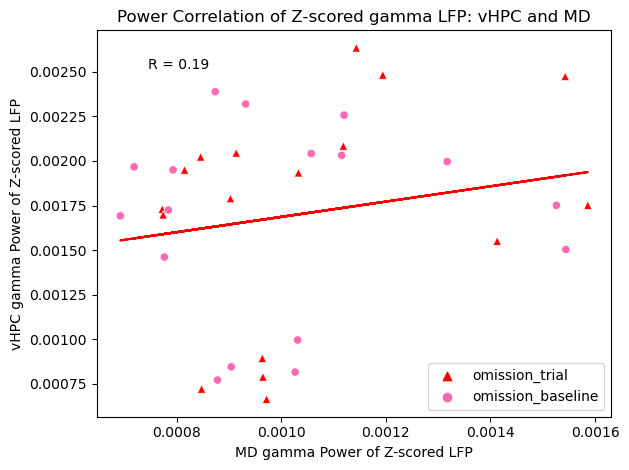

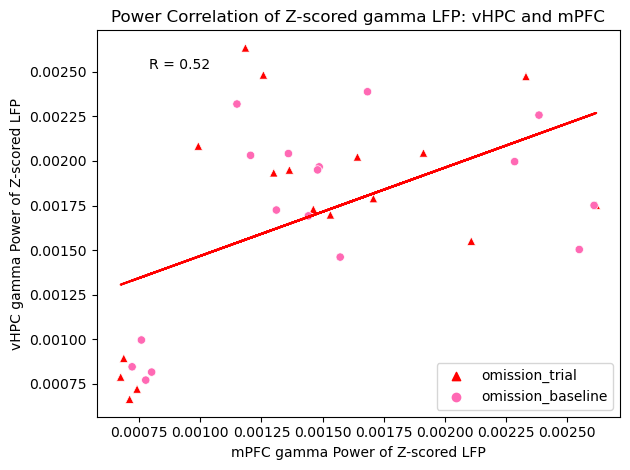

In [152]:
for band in ALL_BANDS:
    band_df = band_to_power_correlation[band]["outlier_removed_df"]
    band_to_power_correlation[band]["region_pair_to_outcome_to_r2"] = defaultdict(nested_dict)
    for outcome in band_df["trial_outcome"].unique():
        outcome_df = band_df[band_df["trial_outcome"] == outcome]
        for region_1, region_2 in band_to_power_correlation[band]["brain_region_pairs"]:
            region_1_basename = region_1.split("_")[0]
            region_2_basename = region_2.split("_")[0]
            
            x = outcome_df[region_1]
            y = outcome_df[region_2]
            
            # Perform linear regression to get the slope, intercept and r-value (correlation coefficient)
            slope, intercept, r_value, p_value, std_err = linregress(x, y)
            # Square the r value to get the r squared value
            r2_value = r_value**2
            band_to_power_correlation[band]["region_pair_to_outcome_to_r2"]["{}_{}".format(region_1.split("_")[0], region_2.split("_")[0])][outcome]["r"] = r_value
            band_to_power_correlation[band]["region_pair_to_outcome_to_r2"]["{}_{}".format(region_1.split("_")[0], region_2.split("_")[0])][outcome]["std"] = std_err
            
            # Create a line of best fit using the slope and intercept
            line = slope * x + intercept
            
            # Create scatter plot
            sns.scatterplot(x=x, y=y, data=outcome_df, hue='outcome_and_trial_or_baseline', palette=BASELINE_OUTCOME_TO_COLOR, style='outcome_and_trial_or_baseline', markers=['^', 'o'])
            
            # Plot line of best fit
            plt.plot(x, line, color='red')
            
            # Add R² value to the plot
            plt.text(0.1, 0.9, f'R = {r_value:.2f}', transform=plt.gca().transAxes)
            
            # Add labels and legend
            plt.title("Power Correlation of Z-scored {} LFP: {} and {}".format(band, region_2_basename, region_1_basename))
            plt.xlabel('{} {} Power of Z-scored LFP'.format(region_1_basename, band))
            plt.ylabel('{} {} Power of Z-scored LFP'.format(region_2_basename, band))
            plt.legend(loc="lower right")
            plt.tight_layout()
            plt.savefig("./proc/power_correlation/{}/{}_{}_{}_power_correlation_of_zscored_{}_lfp.png".format(band, outcome, region_1_basename, region_2_basename, band))
            # Display the plot
            plt.show()

In [163]:
BASELINE_OUTCOME_TO_COLOR

{'lose_trial': 'orange',
 'lose_baseline': array([0.99141869, 0.55072664, 0.23277201, 1.        ]),
 'omission_trial': 'red',
 'omission_baseline': 'hotpink',
 'rewarded_trial': 'green',
 'rewarded_baseline': array([0.45176471, 0.76708958, 0.46120723, 1.        ]),
 'win_trial': 'blue',
 'win_baseline': array([0.41708574, 0.68063053, 0.83823145, 1.        ])}

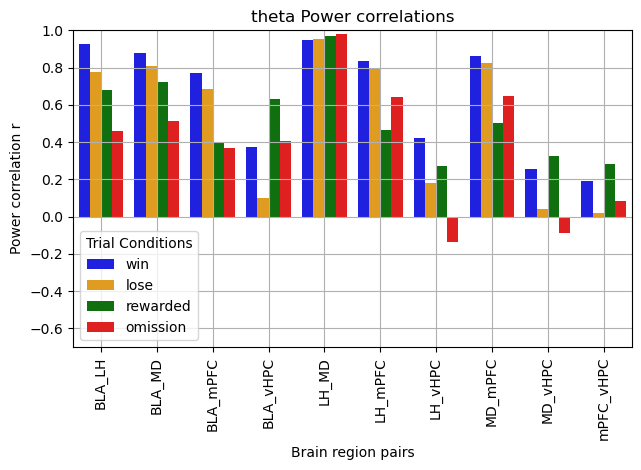

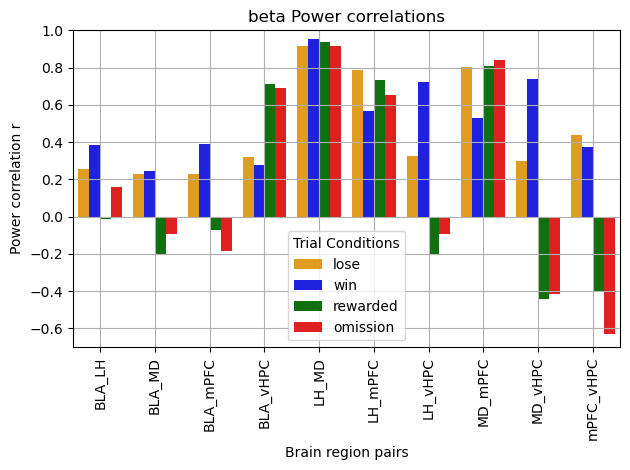

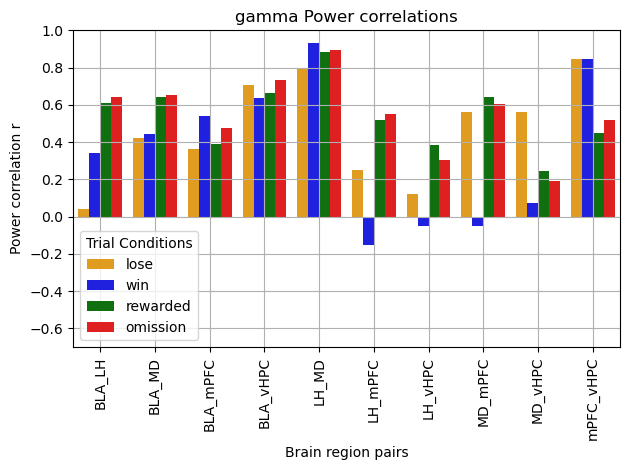

In [167]:
for band in ALL_BANDS:
    # Convert the nested dictionary to a DataFrame
    data = []
    for group_name, group_data in band_to_power_correlation[band]['region_pair_to_outcome_to_r2'].items():
        for bar_name, bar_dict in group_data.items():
            data.append({"Group": group_name, "Bar": bar_name, "r": bar_dict["r"], "std": bar_dict["std"]})
    df = pd.DataFrame(data)
    df["color"] = df["Bar"].map(BASELINE_OUTCOME_TO_COLOR)
    
    # Create the bar plot using seaborn
    # sns.catplot(
    #     data=df, 
    #     x='Group', 
    #     y='r2', 
    #     hue='Bar', 
    #     kind='bar', 
    #     height=4, 
    #     aspect=2,
    #     legend=False,
    #     # yerr=df['std'].values,  # This line adds the SEM bars
    #     # capsize=0.1  # This line adds caps on the error bars
    # )
    
    # Create barplot
    ax = sns.barplot(x='Group', y='r', hue='Bar', data=df, ci=None, palette=df["color"])
    
    # Adding error bars
    groups = df['Group'].unique()
    bars_per_group = df['Bar'].nunique()
    bar_width = 0.8 / bars_per_group
    x_positions = []
    
    for i, group in enumerate(groups):
        num_bars = df[df['Group'] == group].shape[0]
        group_positions = np.linspace(i - bar_width*(num_bars-1)/2, i + bar_width*(num_bars-1)/2, num_bars)
        x_positions.extend(group_positions)
    
    # for i, (r2, sem) in enumerate(zip(df['r'], df['std'])):
    #     plt.errorbar(x_positions[i], r2, yerr=sem, fmt='none', color='black', capsize=5)
    
    
    plt.xticks(rotation=90)
    plt.xlabel("Brain region pairs")
    plt.ylabel("Power correlation r")
    plt.legend(title="Trial Conditions")
    plt.title("{} Power correlations".format(band))
    plt.tight_layout()
    plt.grid()
    plt.ylim(-0.7, 1)
    
    plt.savefig("./proc/power_correlation/all_zscored_{}_lfp_power_correlation.png".format(band))
    # Show the plot
    plt.show()

In [154]:

# Convert the nested dictionary to a DataFrame
data = []
for group_name, group_data in region_pair_to_outcome_to_r2.items():
    for bar_name, bar_dict in group_data.items():
        data.append({"Group": group_name, "Bar": bar_name, "r": bar_dict["r"], "std": bar_dict["std"]})
df = pd.DataFrame(data)

# Create the bar plot using seaborn
# sns.catplot(
#     data=df, 
#     x='Group', 
#     y='r2', 
#     hue='Bar', 
#     kind='bar', 
#     height=4, 
#     aspect=2,
#     legend=False,
#     # yerr=df['std'].values,  # This line adds the SEM bars
#     # capsize=0.1  # This line adds caps on the error bars
# )

# Create barplot
ax = sns.barplot(x='Group', y='r', hue='Bar', data=df, ci=None)

# Adding error bars
groups = df['Group'].unique()
bars_per_group = df['Bar'].nunique()
bar_width = 0.8 / bars_per_group
x_positions = []

for i, group in enumerate(groups):
    num_bars = df[df['Group'] == group].shape[0]
    group_positions = np.linspace(i - bar_width*(num_bars-1)/2, i + bar_width*(num_bars-1)/2, num_bars)
    x_positions.extend(group_positions)

for i, (r2, sem) in enumerate(zip(df['r'], df['std'])):
    plt.errorbar(x_positions[i], r2, yerr=sem, fmt='none', color='black', capsize=5)


plt.xticks(rotation=90)
plt.xlabel("Brain region pairs")
plt.ylabel("Power correlation r")
plt.legend(title="Trial Conditions")
plt.title("Power correlations")
plt.tight_layout()
plt.grid()

plt.savefig("./proc/power_correlation/zscored/all_zscored_lfp_power_correlation.png")
# Show the plot
plt.show()

NameError: name 'region_pair_to_outcome_to_r2' is not defined